<a href="https://colab.research.google.com/github/pfolaa/dsti-labs/blob/main/fraud_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import glob

In [3]:
#cd /content/drive/MyDrive/datasets/

## 1- Data acquisition

###1.1- Get files from repository 

In [5]:
#!wget https://{bucket-name}.s3.eu-west-1.amazonaws.com/{file.zip}

### 1.2 Extract zip file

In [4]:
from zipfile import ZipFile
#ZipFile("{file.zip}").extractall('/content/drive/My Drive/datasets/')

### 1.3 Read all json files and insert into a csv file

In [5]:
import os,json
import pandas as pd

# read json file
def read_Json_And_Insert_Into_CSV(path_file_json, file_csv, root_path):
  os.makedirs(root_path, exist_ok=True) # créer toute l'aborescence du fichier, crée le chemin
  # read all json files
  for file_name in [file for file in os.listdir(path_file_json) if file.endswith('.json')]:
    with open(path_file_json + file_name) as json_file:
      data = json.load(json_file)
      df = pd.DataFrame.from_records(data)

  # convert file to csv
  df.to_csv(f'{root_path}/{file_csv}', sep=';')
  return df # return du fichier csv

###NB: ne pas utiliser les memes noms de variables à l'intérieur des fonctions et à l'extérieur

In [6]:
path_json = '/content/drive/My Drive/datasets/nirra-log-bot/'
root_csv = '/content/drive/My Drive/datasets/nirra-log-bot/csv'
file_csv = 'file_name.csv'

df_raw = read_Json_And_Insert_Into_CSV(path_json, file_csv, root_csv)

In [ ]:
df_raw.head()

### Get total number of @ inside "text" column

In [7]:
 df_raw['text'].str.contains("@").sum() # search total number of @ within text column

37

### Test a slicing

In [11]:
# slicing
#df_raw[df_raw['text'].str.contains("@")] # masque à l'intérieur des crochets

In [8]:
df_raw[df_raw['text'] == None]

,type,subtype,text,ts,bot_id


### Functions used in case of OKRA WEBHOOK, WALLET SUCCESS, SMS SUCCESS, SMS PAYLOAD Types request

In [9]:
import regex
import json

#text_okra_webhook = df_raw['text'][0]
#text_wallet = df_raw['text'][841]
#sms_success = df_raw['text'][12]
#sms_payload = df_raw['text'][11]
def parse_wallet_sms_payload_success(text_type_request):
  ''' la fonction permet de parser les types de requete "Okra WebHook", "Wallet success", 
      "SMS Success" et SMS Payload en object json.
      Elle prend en paramètre le text contenu dans le type de requete,
      elle retourne un objet de type JSON.'''

  pattern = regex.compile(r'\{(?:[^{}]|(?R))*}')
  resul_patt = pattern.findall(text_type_request)
  res = resul_patt[0].replace("\\", " ")
  s = json.loads(res)
  out_dict = {} # dictionnary vide
  for key, value in s.items():
    out_dict[key.strip()] = value # à la clé on passe chaque valeur, strip() enlève les espaces au début et à la fin.


  out_dump = json.dumps(out_dict) # input est un dictionnaire et ça retourne un json sous forme string
  out_wallet_success = json.loads(out_dump) # convertir le string json en object json.
  return out_wallet_success



In [ ]:
# Test Okra WebHook
okra = parse_wallet_sms_payload_success(df_raw['text'][0])
okra


In [ ]:
# Test Wallet Success
wallet_success = parse_wallet_sms_payload_success(df_raw['text'][841])
print(wallet_success.get('account_name'))
print(wallet_success.get('account_number'))
print(wallet_success.get('bvn'))
print(wallet_success.get('requestSuccessful'))
print(wallet_success.get('responseCode'))
print(wallet_success.get('responseMessage'))


In [ ]:
# Test SMS Sucess
sms_succ = parse_wallet_sms_payload_success(df_raw['text'][12])
sms_succ.get('response').get('cost ')
sms_succ.get('response').get('status ')
sms_succ.get('response').get('totalsent ')
sms_succ.get('response')

In [ ]:
# Test SMS Payload
sms_payload = parse_wallet_sms_payload_success(df_raw['text'][11])
print(sms_payload)
print(sms_payload.get('message'))
print(sms_payload.get('phone'))

# Function to handle row with type request "LEADWAY SUCCESS" and concatenate rows
### NB: faire un docstring (''' ''') pour chaque fonction

In [14]:
import re

# la fonction doit prendre en paramètre quelque chose
def parse_and_concatenate_Leadway_Success_Rows(df_raw):
  '''Cette fonction permet de parser et de concatener le texte qui a LEADWAY SUCCESS
     comme type de requete
     elle prend comme paramètre un dataframe et retourne les valeurs suivantes:
     - un texte concatené
     - l'index de la 1ère ligne qu'on va utiliser ensuite pour l'effacer
     - l'index de la dernière ligne qu'on va utiliser ensuite pour l'effacer '''

  first_index = 0
  last_index = 0
  text_leadway_concat = ''
  for index, row in df_raw.iterrows():  # boucler sur les colonnes de type text
      text_row = row['text']  
      if re.search('LEADWAY SUCCESS', text_row):
        text_leadway_concat = text_row
        first_index = index
        first_index +=1
        new_df = df_raw[first_index:]
        for first_index, new_row in new_df.iterrows():
          xxx = new_row['text']      
          if not xxx.startswith('['):          
            first_index += 1
            text_leadway_concat = text_row + xxx       
          elif xxx.startswith('['):
            last_index = first_index-1
            break


  return text_leadway_concat, first_index, last_index


In [ ]:
leadway_succ, first_index_succ, last_index_succ = parse_and_concatenate_Leadway_Success_Rows(df_raw)
leadway_succ, first_index_succ, last_index_succ

### Function to parse row Leadway Success to json

In [16]:
# use this function when type request is LEADWAY SUCCESS
import regex
import json


def parse_Leadway_Success_Row(text_leadway):
  ''' fonction permettant de parser le text concatené pour le type de requet LEADWAY SUCCESS
      elle retourner un dictionnaire.'''
  pattern = regex.compile(r'\{(?:[^{}]|(?R))*}')
  resul_patt = pattern.findall(text_leadway)
  resul_patt[0] = resul_patt[0].replace("\\", "")
  x = resul_patt[0].replace("make,", "")
  y = x.replace('""makeName"', '"makeName"')
  z = json.loads(y)
  vehicleMake = z.get('vehicleMake')
  leadway_dict = {}
  for element in vehicleMake:
    leadway_dict[element['id']] = element['makeName']

  return leadway_dict



In [ ]:
print(leadway_succ)

In [ ]:
# TEST LEADWAY SUCCESS
resultat_leadway = parse_Leadway_Success_Row(leadway_succ)

for i in resultat_leadway:
  print(resultat_leadway.get(i))



In [ ]:
2356 in df_raw.index

### Function to handle log level "Error"
NB: faire un docstring (''' ''') pour chaque fonction

In [20]:
import regex
import json

def parse_Error_Row(error_row):
  error_row = error_row.replace('"', "'")
  pattern = regex.compile(r"{?[a-z :A-Z 0-9\\,=_`']+selfie")
  resul_patt = pattern.findall(error_row)
  res = resul_patt[0].replace("\\", " ")
  res = res.replace("'name'", "name").replace("`", "").replace("'18'", "18").replace("'monthly'", "monthly")
  res = res+'"}'
  res = res.replace("'", '"')
  s = json.loads(res)
  out_error_dict = {} # dictionnary vide
  for key, value in s.items():
    out_error_dict[key.strip()] = value # à la clé on passe chaque valeur, strip() enlève les espaces au début et à la fin.

  out_error_dump = json.dumps(out_error_dict) # input est un dictionnaire et ça retourne un json sous forme string
  out_error_text = json.loads(out_error_dump) # convertir le string json en object json.
  return out_error_text


In [ ]:
error_text = parse_Error_Row(df_raw['text'][2355])
print(error_text)
print(error_text.get('code'))
print(error_text.get('errno'))
print(error_text.get('sqlMessage'))
print(error_text.get('sqlState'))
print(error_text.get('index'))
print(error_text.get('sql'))

### Function to convert data to timestamp

In [21]:
import datetime

# function to convert date to Timestamp
def convertToTimestamp(str):
  element = datetime.datetime.strptime(str,"%Y-%m-%dT%H:%M:%S.%fZ")
  return datetime.datetime.timestamp(element)

In [22]:
timestamp = convertToTimestamp('2021-09-05T07:03:55.223Z')
timestamp

1630825435.223

## 2 Data model
### 2.1 Parse rows of dataset

### 2.1.1 créer un dictionnary pour les regex.

In [23]:
type_request_dictionnary = {}
regex_list_api_request = []
regex_list_api_request.append('[\w.+-]+@[\w-]+\.[\w.-]+')
regex_list_api_request.append('/[/a-z 0-9?=&;/_A-Z+]+')
regex_list_api_request.append('(\d{4})-(\d\d)-(\d\d)T(\d\d):(\d\d):(\d\d).(\d{3})*[a-zA-Z]')
regex_list_api_request.append('[0-9]+')

type_request_dictionnary['API REQUEST'] = regex_list_api_request

regex_list_client_mobile = []
regex_list_client_mobile.append('[\w.+-]+@[\w-]+\.[\w.-]+')
regex_list_client_mobile.append('(\d{4})-(\d\d)-(\d\d)T(\d\d):(\d\d):(\d\d).(\d{3})*[a-zA-Z]')
regex_list_client_mobile.append('[0-9]+')

type_request_dictionnary['CLIENT MOBILE LOGIN'] = regex_list_client_mobile

type_request_dictionnary['SMS PAYLOAD'] = '\{(?:[^{}]|(?R))*}'
type_request_dictionnary['SMS SUCCESS'] = '\{(?:[^{}]|(?R))*}'
type_request_dictionnary['WALLET SUCCESS'] = '\{(?:[^{}]|(?R))*}'
type_request_dictionnary['LEADWAY SUCCESS'] = '\{(?:[^{}]|(?R))*}'

### 2.1.2 Functions. 

### Handle DataFrame Error

In [24]:
import re
import regex
import json

def parse_row_error(df_):
  log_level_col = []
  api_request_col = []
  type_request_col = []
  phone_Col = []
  date_col = []
  endpoint_Col = []
  email_col = []
  message_sms_payload_col = []
  totalsent_col = []
  cost_col = []
  status_col = []
  account_number_col = []
  account_name_col = []
  bvn_col = []
  requestSuccessful_col = []
  responseMessage_col = []
  responseCode_col = []
  error_code_col = []
  error_number_col = []
  error_sql_message_col = []
  error_sql_state_col = []
  error_index_col = []
  error_sql_col = []

  
  list_column_none_level_log_error = []
  list_column_none = [message_sms_payload_col, totalsent_col, cost_col, status_col, email_col,
                      phone_Col, endpoint_Col, date_col, bvn_col, requestSuccessful_col, responseMessage_col,
                      responseCode_col, account_name_col, account_number_col]
  
  list_all_colum = []
  list_all_colum = [type_request_col, phone_Col, date_col, endpoint_Col, log_level_col, email_col, 
                    message_sms_payload_col, totalsent_col, cost_col, status_col, account_number_col,
                    account_name_col, bvn_col, requestSuccessful_col, responseMessage_col, responseCode_col,
                    error_code_col, error_number_col, error_sql_message_col, error_sql_state_col, 
                    error_index_col, error_sql_col]

  for index, row in df_.iterrows():
    str_text = row['text']
    
    if not str_text.startswith('['):
      for i in range(len(list_all_colum)):
          list_all_colum[i].append(None)
    
    if re.search('error', str_text):
        log_level = re.search('error', str_text)
          
        try:
          log_level_col.append(log_level.group(0))
        except AttributeError:
          log_level_col.append(None)

        if re.search('LOAN ERROR', str_text):
            type_of_request = re.search('LOAN ERROR', str_text)
            loan_error = parse_Error_Row(str_text) 
            try:
              error_code_col.append(loan_error.get('code'))
              print(error_code_col)
            except AttributeError:
              error_code_col.append(None)
            try:
              print(loan_error.get('errno'))
              error_number_col.append(loan_error.get('errno'))
              print('error number :')
              print(error_number_col)
            except AttributeError:
              error_number_col.append(None)
            try:
              error_sql_message_col.append(loan_error.get('sqlMessage'))
            except AttributeError:
              error_sql_message_col.append(None)
            try:
              error_sql_state_col.append(loan_error.get('sqlState'))
            except AttributeError:
              error_sql_state_col.append(None)
            try:
              error_index_col.append(loan_error.get('index'))
            except AttributeError:
              error_index_col.append(None)
            try:
              error_sql_col.append(loan_error.get('sql'))
            except AttributeError:
              error_sql_col.append(None)       

            try:
                type_request_col.append(type_of_request.group(0))
            except AttributeError:
                type_request_col.append(None)

            for p in range(len(list_column_none)):
              list_column_none[p].append(None)
  
  
  #for x in range(len(list_all_colum)):
   # print(len(list_all_colum[x]))
  
  df_['Type_Request'] = type_request_col
  df_['Phone_Number'] = phone_Col
  df_['Date'] = date_col
  df_['EndPoint'] = endpoint_Col
  df_['Log_Level'] = log_level_col
  df_['Email'] = email_col
  df_['Message SMS Payload'] = message_sms_payload_col
  df_['Total Sent'] = totalsent_col
  df_['Cost'] = cost_col
  df_['Status'] = status_col
  df_['Account Number'] = account_number_col
  df_['Account Name'] = account_name_col
  df_['BVN'] = bvn_col
  df_['Request Successful'] = requestSuccessful_col
  df_['Response Message'] = responseMessage_col
  df_['Response Code'] = responseCode_col
  df_['Error Code'] = error_code_col
  df_['Error Number'] = error_number_col
  df_['Error Sql Message'] = error_sql_message_col
  df_['Error Sql State'] = error_sql_state_col
  df_['Error Index'] = error_index_col
  df_['Error Sql'] = error_sql_col


  return df_

### Handle DataFrame for error

In [ ]:
df_error = df_raw[df_raw['text'].str.contains('LOAN ERROR')]
resutat_error = parse_row_error(df_error)
resutat_error.head()

In [31]:
#df_raw = df_raw.drop(2355)

In [ ]:
df_raw.info()

### Handle DataFrame for API REQUEST Type request

In [26]:
import re
import regex
import json

def parse_row_api_request(df_api_request):
  log_level_col = []
  api_request_col = []
  type_request_col = []
  phone_Col = []
  date_col = []
  endpoint_Col = []
  email_col = []
  message_sms_payload_col = []
  totalsent_col = []
  cost_col = []
  status_col = []
  account_number_col = []
  account_name_col = []
  bvn_col = []
  requestSuccessful_col = []
  responseMessage_col = []
  responseCode_col = []

  list_column_none_api_request = []
  list_column_none_api_request = [message_sms_payload_col, totalsent_col, cost_col, status_col,
                                  bvn_col, requestSuccessful_col, responseMessage_col,
                                  responseCode_col, account_name_col, account_number_col]
  
  list_all_colum = []
  list_all_colum = [type_request_col, phone_Col, date_col, endpoint_Col, log_level_col, email_col, 
                    message_sms_payload_col, totalsent_col, cost_col, status_col, account_number_col,
                    account_name_col, bvn_col, requestSuccessful_col, responseMessage_col, responseCode_col]

  for index, row in df_api_request.iterrows():
    str_text = row['text']
    
    if not str_text.startswith('['):
      for i in range(len(list_all_colum)):
          list_all_colum[i].append(None)

    # check if the row contains "info" string
    if re.search('info', str_text):
        log_level = re.search('info', str_text)
        try:
          log_level_col.append(log_level.group(0))
        except AttributeError:
          log_level_col.append(None)        
        # check if the row contains an email address 
        # pour tous les types request créer un dictionnaire dans lequel mapper
        # key = type de request et value = les regex définis
        # pour chaque condition IF créer une liste de colonnes auxquelles affecter None
        if 'mailto' in str_text:
            if re.search('API REQUEST', str_text):
                type_of_request = re.search('API REQUEST', str_text)                
                phone_or_email_api_req = re.search(type_request_dictionnary['API REQUEST'][0], str_text)                              
                endpoint = re.search(type_request_dictionnary['API REQUEST'][1], str_text)
                pattern = type_request_dictionnary['API REQUEST'][2]
                datepattern = re.compile("(?:%s)"%(pattern))
                datematcher = datepattern.search(str_text)  # extract date

                for i in range(len(list_column_none_api_request)):
                  list_column_none_api_request[i].append(None)
                               
                try:
                  type_request_col.append(type_of_request.group(0)) # add type request inside type request column
                except AttributeError:
                  type_request_col.append(None)               
                try:
                  email_col.append(phone_or_email_api_req.group(0)) # add email inside email column
                  phone_Col.append(None)  # in this case there is no phone number
                except AttributeError:
                  email_col.append(None)
                try:
                  endpoint_Col.append(endpoint.group(0)) # add endpoint inside endpoint column
                except AttributeError:
                  endpoint_Col.append(None)
                try:
                  date_col.append(convertToTimestamp(datematcher.group(0))) # convert date to timestamp and add it inside date column
                except AttributeError:
                  date_col.append(None)
              

        elif 'mailto' not in str_text:
            if re.search('API REQUEST', str_text):
                type_of_request = re.search('API REQUEST', str_text)                            
                # extract a phone number for API REQUEST
                phone_or_email_api_req = re.search(type_request_dictionnary['API REQUEST'][3], str_text)                              
                endpoint = re.search(type_request_dictionnary['API REQUEST'][1], str_text)
                pattern = type_request_dictionnary['API REQUEST'][2]
                datepattern = re.compile("(?:%s)"%(pattern))
                datematcher = datepattern.search(str_text)  # extract date

                for i in range(len(list_column_none_api_request)):
                  list_column_none_api_request[i].append(None)

                try:
                  phone_Col.append(phone_or_email_api_req.group(0)) # add phone number inside phone number column
                  email_col.append(None) # in this case there is no email address
                except AttributeError:
                  phone_Col.append(None)
                try:
                  type_request_col.append(type_of_request.group(0))
                except AttributeError:
                  type_request_col.append(None)
                try:
                  endpoint_Col.append(endpoint.group(0)) # add endpoint inside endpoint column
                except AttributeError:
                  endpoint_Col.append(None)
                try:
                  date_col.append(convertToTimestamp(datematcher.group(0))) # convert date to timestamp and add it inside date column
                except AttributeError:
                  date_col.append(None)

  df_api_request['Type_Request'] = type_request_col
  df_api_request['Phone_Number'] = phone_Col
  df_api_request['Date'] = date_col
  df_api_request['EndPoint'] = endpoint_Col
  df_api_request['Log_Level'] = log_level_col
  df_api_request['Email'] = email_col
  df_api_request['Message SMS Payload'] = message_sms_payload_col
  df_api_request['Total Sent'] = totalsent_col
  df_api_request['Cost'] = cost_col
  df_api_request['Status'] = status_col
  df_api_request['Account Number'] = account_number_col
  df_api_request['Account Name'] = account_name_col
  df_api_request['BVN'] = bvn_col
  df_api_request['Request Successful'] = requestSuccessful_col
  df_api_request['Response Message'] = responseMessage_col
  df_api_request['Response Code'] = responseCode_col
 
  return df_api_request

In [ ]:
df_api_request_ = df_raw[df_raw['text'].str.contains('API REQUEST')]
resutat_df_api = parse_row_api_request(df_api_request_)
resutat_df_api.head(10)
resutat_df_api.info()

### Handle DataFrame for Client Mobile Login Type request

In [28]:
import re
import regex
import json

def parse_row_client_mobile_login(df_client_mob):
  log_level_col = []
  api_request_col = []
  type_request_col = []
  phone_Col = []
  date_col = []
  endpoint_Col = []
  email_col = []
  message_sms_payload_col = []
  totalsent_col = []
  cost_col = []
  status_col = []
  account_number_col = []
  account_name_col = []
  bvn_col = []
  requestSuccessful_col = []
  responseMessage_col = []
  responseCode_col = []

  list_column_none_client_mobile = []
  list_column_none_client_mobile = [message_sms_payload_col, totalsent_col, cost_col, status_col,
                                  account_number_col, bvn_col, requestSuccessful_col, responseMessage_col,
                                  responseCode_col, account_name_col, endpoint_Col]
  
  list_all_colum = []
  list_all_colum = [type_request_col, phone_Col, date_col, endpoint_Col, log_level_col, email_col, 
                    message_sms_payload_col, totalsent_col, cost_col, status_col, account_number_col,
                    account_name_col, bvn_col, requestSuccessful_col, responseMessage_col, responseCode_col]

  for index, row in df_client_mob.iterrows():
    str_text = row['text']
    
    if not str_text.startswith('['):
      for i in range(len(list_all_colum)):
          list_all_colum[i].append(None)

    # check if the row contains "info" string
    if re.search('info', str_text):
        log_level = re.search('info', str_text)
        try:
          log_level_col.append(log_level.group(0))
        except AttributeError:
          log_level_col.append(None)        
        # check if the row contains an email address 
        # pour tous les types request créer un dictionnaire dans lequel mapper
        # key = type de request et value = les regex définis
        # pour chaque condition IF créer une liste de colonnes auxquelles affecter None
        if 'mailto' in str_text:
            if re.search('CLIENT MOBILE LOGIN', str_text):   # CLIENT MOBILE LOGIN with email address
                  type_of_request = re.search('CLIENT MOBILE LOGIN', str_text)
                  # extract address email for CLIENT MOBILE LOGIN
                  phone_or_email_client_mobile = re.search(type_request_dictionnary['CLIENT MOBILE LOGIN'][0], str_text)                               
                  pattern = type_request_dictionnary['CLIENT MOBILE LOGIN'][1]
                  datepattern = re.compile("(?:%s)"%(pattern))
                  datematcher = datepattern.search(str_text)  # extract date for CLIENT MOBILE LOGIN type request
                  
                  for j in range(len(list_column_none_client_mobile)):
                    list_column_none_client_mobile[j].append(None)

                  try:
                    type_request_col.append(type_of_request.group(0)) # add type request inside type request column
                  except AttributeError:
                    type_request_col.append(None) 
                  try:
                    email_col.append(phone_or_email_client_mobile.group(0)) # add email inside email column
                    phone_Col.append(None)  # in this case there is no phone number
                  except AttributeError:
                    email_col.append(None)
                  try:
                    date_col.append(convertToTimestamp(datematcher.group(0))) # convert date to timestamp and add it inside date column
                  except AttributeError:
                    date_col.append(None)

        elif 'mailto' not in str_text:
            if re.search('CLIENT MOBILE LOGIN', str_text): # when type request is CLIENT MOBILE LOGIN, there is no EndPoint
                type_of_request = re.search('CLIENT MOBILE LOGIN', str_text)
                # extract a phone number for CLIENT MOBILE LOGIN
                phone_or_email_client_mobile = re.search(type_request_dictionnary['CLIENT MOBILE LOGIN'][2], str_text)                  
                pattern = type_request_dictionnary['CLIENT MOBILE LOGIN'][1]
                datepattern = re.compile("(?:%s)"%(pattern))
                datematcher = datepattern.search(str_text)  # extract date

                for j in range(len(list_column_none_client_mobile)):
                    list_column_none_client_mobile[j].append(None)

                try:
                  phone_Col.append(phone_or_email_client_mobile.group(0))
                  email_col.append(None)
                except AttributeError:
                  phone_Col.append(None)
                try:
                  type_request_col.append(type_of_request.group(0))
                except AttributeError:
                  type_request_col.append(None)
                try:
                  date_col.append(convertToTimestamp(datematcher.group(0))) # convert date to timestamp and add it inside date column
                except AttributeError:
                  date_col.append(None) 

  df_client_mob['Type_Request'] = type_request_col
  df_client_mob['Phone_Number'] = phone_Col
  df_client_mob['Date'] = date_col
  df_client_mob['EndPoint'] = endpoint_Col
  df_client_mob['Log_Level'] = log_level_col
  df_client_mob['Email'] = email_col
  df_client_mob['Message SMS Payload'] = message_sms_payload_col
  df_client_mob['Total Sent'] = totalsent_col
  df_client_mob['Cost'] = cost_col
  df_client_mob['Status'] = status_col
  df_client_mob['Account Number'] = account_number_col
  df_client_mob['Account Name'] = account_name_col
  df_client_mob['BVN'] = bvn_col
  df_client_mob['Request Successful'] = requestSuccessful_col
  df_client_mob['Response Message'] = responseMessage_col
  df_client_mob['Response Code'] = responseCode_col
 
  return df_client_mob

In [ ]:
df_client_mobile_login = df_raw[df_raw['text'].str.contains('CLIENT MOBILE LOGIN')]
resutat_df_client_mobile_login = parse_row_client_mobile_login(df_client_mobile_login)
resutat_df_client_mobile_login.head()
resutat_df_client_mobile_login.info()



### Handle DataFrame for SMS PAYLOAD Type request

In [30]:
import re
import regex
import json

def parse_row_sms_payload_function(df_sms_payload):
  log_level_col = []
  api_request_col = []
  type_request_col = []
  phone_Col = []
  date_col = []
  endpoint_Col = []
  email_col = []
  message_sms_payload_col = []
  totalsent_col = []
  cost_col = []
  status_col = []
  account_number_col = []
  account_name_col = []
  bvn_col = []
  requestSuccessful_col = []
  responseMessage_col = []
  responseCode_col = []
  
  list_column_none_sms_payload = []
  list_column_none_sms_payload = [totalsent_col, cost_col, status_col,
                                  account_number_col, bvn_col, requestSuccessful_col, responseMessage_col,
                                  responseCode_col, account_name_col, email_col, endpoint_Col, date_col]
  
  list_all_colum = []
  list_all_colum = [type_request_col, phone_Col, date_col, endpoint_Col, log_level_col, email_col, 
                    message_sms_payload_col, totalsent_col, cost_col, status_col, account_number_col,
                    account_name_col, bvn_col, requestSuccessful_col, responseMessage_col, responseCode_col]

  for index, row in df_sms_payload.iterrows():
    str_text = row['text']
    
    if not str_text.startswith('['):
      for i in range(len(list_all_colum)):
          list_all_colum[i].append(None)

    # check if the row contains "info" string
    if re.search('info', str_text):
        log_level = re.search('info', str_text)
        try:
          log_level_col.append(log_level.group(0))
        except AttributeError:
          log_level_col.append(None)             
        if 'mailto' not in str_text:
            if re.search('SMS PAYLOAD', str_text):
                type_of_request = re.search('SMS PAYLOAD', str_text)            
                sms_payload = parse_wallet_sms_payload_success(str_text)               
                for l in range(len(list_column_none_sms_payload)):
                    list_column_none_sms_payload[l].append(None)             
                try:
                  type_request_col.append(type_of_request.group(0))
                except AttributeError:
                  type_request_col.append(None)
                try:
                  phone_Col.append(sms_payload.get('phone'))
                except AttributeError:
                  phone_Col.append(None)
                try:
                  message_sms_payload_col.append(sms_payload.get('message'))
                except AttributeError:
                  message_sms_payload_col.append(None)
                     
        elif re.search('OKRA PAYLOAD', str_text): # Nothing
          type_of_request = re.search('OKRA PAYLOAD', str_text)
        elif re.search('OKRA SUCCESS', str_text):   # Nothing
          type_of_request = re.search('OKRA SUCCESS', str_text)
        elif re.search('VTPASS SUCCESS', str_text):   # Nothing
          type_of_request = re.search('VTPASS SUCCESS', str_text)  

  df_sms_payload['Type_Request'] = type_request_col
  df_sms_payload['Phone_Number'] = phone_Col
  df_sms_payload['Date'] = date_col
  df_sms_payload['EndPoint'] = endpoint_Col
  df_sms_payload['Log_Level'] = log_level_col
  df_sms_payload['Email'] = email_col
  df_sms_payload['Message SMS Payload'] = message_sms_payload_col
  df_sms_payload['Total Sent'] = totalsent_col
  df_sms_payload['Cost'] = cost_col
  df_sms_payload['Status'] = status_col
  df_sms_payload['Account Number'] = account_number_col
  df_sms_payload['Account Name'] = account_name_col
  df_sms_payload['BVN'] = bvn_col
  df_sms_payload['Request Successful'] = requestSuccessful_col
  df_sms_payload['Response Message'] = responseMessage_col
  df_sms_payload['Response Code'] = responseCode_col
 
  return df_sms_payload


In [ ]:
df_sms_payload_ = df_raw[df_raw['text'].str.contains('SMS PAYLOAD')]
resutat_df_sms_payload = parse_row_sms_payload_function(df_sms_payload_)
resutat_df_sms_payload.head()
#resutat_df_sms_payload.info()

### Handle DataFrame for SMS Success Type request

In [32]:
import re
import regex
import json

def parse_row_sms_success_function(df_sms_success):
  log_level_col = []
  api_request_col = []
  type_request_col = []
  phone_Col = []
  date_col = []
  endpoint_Col = []
  email_col = []
  message_sms_payload_col = []
  totalsent_col = []
  cost_col = []
  status_col = []
  account_number_col = []
  account_name_col = []
  bvn_col = []
  requestSuccessful_col = []
  responseMessage_col = []
  responseCode_col = []
  
  list_column_none_sms_success = []
  list_column_none_sms_success = [message_sms_payload_col, account_number_col, bvn_col, requestSuccessful_col, 
                                  responseMessage_col, responseCode_col, account_name_col, email_col, 
                                  phone_Col, endpoint_Col, date_col]
  
  list_all_colum = []
  list_all_colum = [type_request_col, phone_Col, date_col, endpoint_Col, log_level_col, email_col, 
                    message_sms_payload_col, totalsent_col, cost_col, status_col, account_number_col,
                    account_name_col, bvn_col, requestSuccessful_col, responseMessage_col, responseCode_col]

  for index, row in df_sms_success.iterrows():
    str_text = row['text']
    
    if not str_text.startswith('['):
      for i in range(len(list_all_colum)):
          list_all_colum[i].append(None)

    # check if the row contains "info" string
    if re.search('info', str_text):
        log_level = re.search('info', str_text)
        try:
          log_level_col.append(log_level.group(0))
        except AttributeError:
          log_level_col.append(None)             
        if 'mailto' not in str_text:
            if re.search('SMS SUCCESS', str_text): 
                type_of_request = re.search('SMS SUCCESS', str_text)
                sms_success = parse_wallet_sms_payload_success(str_text)                
                for m in range(len(list_column_none_sms_success)):
                    list_column_none_sms_success[m].append(None) 
           
                try:
                  type_request_col.append(type_of_request.group(0))
                except AttributeError:
                  type_request_col.append(None)
                try:                 
                  totalsent_col.append(sms_success.get('response').get('totalsent '))
                except AttributeError:
                  totalsent_col.append(None)
                try:                 
                  cost_col.append(sms_success.get('response').get('cost '))
                except AttributeError:
                  cost_col.append(None)
                try:                 
                  status_col.append(sms_success.get('response').get('status '))
                except AttributeError:
                  status_col.append(None)
                     
        elif re.search('OKRA PAYLOAD', str_text): # Nothing
          type_of_request = re.search('OKRA PAYLOAD', str_text)
        elif re.search('OKRA SUCCESS', str_text):   # Nothing
          type_of_request = re.search('OKRA SUCCESS', str_text)
        elif re.search('VTPASS SUCCESS', str_text):   # Nothing
          type_of_request = re.search('VTPASS SUCCESS', str_text)    

  df_sms_success['Type_Request'] = type_request_col
  df_sms_success['Phone_Number'] = phone_Col
  df_sms_success['Date'] = date_col
  df_sms_success['EndPoint'] = endpoint_Col
  df_sms_success['Log_Level'] = log_level_col
  df_sms_success['Email'] = email_col
  df_sms_success['Message SMS Payload'] = message_sms_payload_col
  df_sms_success['Total Sent'] = totalsent_col
  df_sms_success['Cost'] = cost_col
  df_sms_success['Status'] = status_col
  df_sms_success['Account Number'] = account_number_col
  df_sms_success['Account Name'] = account_name_col
  df_sms_success['BVN'] = bvn_col
  df_sms_success['Request Successful'] = requestSuccessful_col
  df_sms_success['Response Message'] = responseMessage_col
  df_sms_success['Response Code'] = responseCode_col
 
  return df_sms_success


In [ ]:
df_sms_success_ = df_raw[df_raw['text'].str.contains('SMS SUCCESS')]
resutat_df_sms_success = parse_row_sms_success_function(df_sms_success_)
resutat_df_sms_success.head()
#resutat_df_sms_success.info()

### Handle DataFrame for WALLET SUCCESS Type request

In [34]:
import re
import regex
import json

def parse_row_wallet_success_function(df_wallet_success):
  log_level_col = []
  api_request_col = []
  type_request_col = []
  phone_Col = []
  date_col = []
  endpoint_Col = []
  email_col = []
  message_sms_payload_col = []
  totalsent_col = []
  cost_col = []
  status_col = []
  account_number_col = []
  account_name_col = []
  bvn_col = []
  requestSuccessful_col = []
  responseMessage_col = []
  responseCode_col = []

  list_column_none_wallet_success = []
  list_column_none_wallet_success = [totalsent_col, message_sms_payload_col, cost_col, status_col, 
                                     email_col, phone_Col, endpoint_Col, date_col]
  
  list_all_colum = []
  list_all_colum = [type_request_col, phone_Col, date_col, endpoint_Col, log_level_col, email_col, 
                    message_sms_payload_col, totalsent_col, cost_col, status_col, account_number_col,
                    account_name_col, bvn_col, requestSuccessful_col, responseMessage_col, responseCode_col]
  
  for index, row in df_wallet_success.iterrows():
    str_text = row['text']
    
    if not str_text.startswith('['):
      for i in range(len(list_all_colum)):
          list_all_colum[i].append(None)

    # check if the row contains "info" string
    if re.search('info', str_text):
        log_level = re.search('info', str_text)
        try:
          log_level_col.append(log_level.group(0))
        except AttributeError:
          log_level_col.append(None)             
        if 'mailto' not in str_text:
            if re.search('WALLET SUCCESS', str_text):
                  wallet_success = parse_wallet_sms_payload_success(str_text)
                  type_of_request = re.search('WALLET SUCCESS', str_text)

                  try:
                    type_request_col.append(type_of_request.group(0))
                  except AttributeError:
                    type_request_col.append(None)
                  try:
                    account_number_col.append(wallet_success.get('account_number'))
                  except AttributeError:
                    account_number_col.append(None)
                  try:
                    account_name_col.append(wallet_success.get('account_name'))
                  except AttributeError:
                    account_name_col.append(None)
                  try:
                    bvn_col.append(wallet_success.get('bvn'))
                  except AttributeError:
                    bvn_col.append(None)
                  try:
                    requestSuccessful_col.append(wallet_success.get('requestSuccessful'))
                  except AttributeError:
                    requestSuccessful_col.append(None)
                  try:
                    responseMessage_col.append((wallet_success.get('responseMessage')))
                  except AttributeError:
                    responseMessage_col.append(None)
                  try:
                    responseCode_col.append((wallet_success.get('responseCode')))
                  except AttributeError:
                    responseCode_col.append(None)
                  for n in range(len(list_column_none_wallet_success)):
                    list_column_none_wallet_success[n].append(None) 

                     
        elif re.search('OKRA PAYLOAD', str_text): # Nothing
          type_of_request = re.search('OKRA PAYLOAD', str_text)
        elif re.search('OKRA SUCCESS', str_text):   # Nothing
          type_of_request = re.search('OKRA SUCCESS', str_text)
        elif re.search('VTPASS SUCCESS', str_text):   # Nothing
          type_of_request = re.search('VTPASS SUCCESS', str_text)    

  df_wallet_success['Type_Request'] = type_request_col
  df_wallet_success['Phone_Number'] = phone_Col
  df_wallet_success['Date'] = date_col
  df_wallet_success['EndPoint'] = endpoint_Col
  df_wallet_success['Log_Level'] = log_level_col
  df_wallet_success['Email'] = email_col
  df_wallet_success['Message SMS Payload'] = message_sms_payload_col
  df_wallet_success['Total Sent'] = totalsent_col
  df_wallet_success['Cost'] = cost_col
  df_wallet_success['Status'] = status_col
  df_wallet_success['Account Number'] = account_number_col
  df_wallet_success['Account Name'] = account_name_col
  df_wallet_success['BVN'] = bvn_col
  df_wallet_success['Request Successful'] = requestSuccessful_col
  df_wallet_success['Response Message'] = responseMessage_col
  df_wallet_success['Response Code'] = responseCode_col
 
  return df_wallet_success
             

In [ ]:
df_wallet_success_ = df_raw[df_raw['text'].str.contains('WALLET SUCCESS')]
resutat_df_wallet_success = parse_row_wallet_success_function(df_wallet_success_)
resutat_df_wallet_success.head()
#resutat_df_wallet_success.info()

In [ ]:
okra = parse_wallet_sms_payload_success(df_raw['text'][0])
print(okra.get('authorization').get('customer '))
print(okra.get('authorization').get('env '))
print(okra.get('authorization').get('owner '))

### Handle DataFrame for OKRA WEBHOOK Type request

In [37]:
import re
import regex
import json

def parse_row_okra_webhook_function(df_okra):
  log_level_col = []
  api_request_col = []
  type_request_col = []
  phone_Col = []
  date_col = []
  endpoint_Col = []
  email_col = []
  message_sms_payload_col = []
  totalsent_col = []
  cost_col = []
  status_col = []
  account_number_col = []
  account_name_col = []
  bvn_col = []
  requestSuccessful_col = []
  responseMessage_col = []
  responseCode_col = []
  accountId_col = []
  authorization_v_col = []
  authorization_id_col = []
  authorization_customer_col = []
  authorization_account_col = []
  authorization_account_id_col = []
  authorization_account_manual_col = []
  authorization_account_name_col = []
  authorization_account_nuban_col = []
  authorization_account_bank_col = []
  authorization_account_created_at_col = []
  authorization_account_last_updated_col = []
  authorization_account_balance_col = []
  authorization_account_customer_col = []
  authorization_account_type_col = []
  authorization_account_currency_col = []
  authorization_accounts_col = []
  authorization_amount_col = []
  authorization_bank_col = []
  authorization_created_at_col = []
  authorization_currency_col = []
  authorization_customerDetails_col = []
  authorization_disconnect_col = []
  authorization_disconnected_at_col = []
  authorization_duration_col = []
  authorization_env_col = []
  authorization_garnish_col = []
  authorization_initialAmount_col = []
  authorization_initiated_col = []
  authorization_last_updated_col = []
  authorization_link_col = []
  authorization_next_payment_col = []
  authorization_owner_col = []
  authorization_payLink_col = []
  authorization_type_col = []
  authorization_used_col = []
  authorizationId_col = []
  bankId_col = []
  bankName_col = []
  bankSlug_col = []
  bankType_col = []
  callbackURL_col = []
  callback_code_col = []
  callback_type_col = []
  callback_url_col = []
  code_col = []
  country_col = []
  current_project_col = []
  customerEmail_col = []
  customerId_col = []
  ended_at_col = []
  env_col = []
  extras_col = []
  identityType_col = []
  login_type_col = []
  message_col = []
  meta_col = []
  method_col = []
  options_col = []
  owner_col = []
  record_col = []
  recordId_col = []
  started_at_col = []
  status_webhook_col = []
  token_col = []
  type_col = []

  list_column_none_okra_webhook = []
  list_column_none_okra_webhook = [api_request_col, account_number_col, account_name_col, totalsent_col, 
                                   message_sms_payload_col, cost_col, status_col, responseCode_col,
                                   bvn_col, requestSuccessful_col, responseMessage_col, email_col, phone_Col, 
                                   endpoint_Col, date_col]
  
  list_all_colum = []
  list_all_colum = [type_request_col, phone_Col, date_col, endpoint_Col, log_level_col, email_col, 
                    message_sms_payload_col, totalsent_col, cost_col, status_col, account_number_col,
                    account_name_col, bvn_col, requestSuccessful_col, responseMessage_col, responseCode_col]

  for index, row in df_okra.iterrows():
    str_text = row['text']
    
    if not str_text.startswith('['):
      for i in range(len(list_all_colum)):
          list_all_colum[i].append(None)

    # check if the row contains "info" string
    if re.search('info', str_text):
        log_level = re.search('info', str_text)
        try:
          log_level_col.append(log_level.group(0))
        except AttributeError:
          log_level_col.append(None)             
        if 'mailto' not in str_text:
            if re.search('OKRA WEBHOOK', str_text):
                  type_of_request = re.search('OKRA WEBHOOK', str_text)
                  okra_webhook = parse_wallet_sms_payload_success(str_text)                  
                  accountId_col.append(okra_webhook.get('accountId'))
                  authorization_v_col.append(okra_webhook.get('authorization').get('__v '))
                  authorization_id_col.append(okra_webhook.get('authorization').get('_id '))
                  authorization_customer_col.append(okra_webhook.get('authorization').get('customer '))
                  authorization_account_col.append(okra_webhook.get('authorization').get('account '))
                  authorization_account_id_col.append(okra_webhook.get('authorization').get('account ')[0].get('_id '))
                  authorization_account_manual_col.append(okra_webhook.get('authorization').get('account ')[0].get('manual '))
                  authorization_account_name_col.append(okra_webhook.get('authorization').get('account ')[0].get('name '))
                  authorization_account_nuban_col.append(okra_webhook.get('authorization').get('account ')[0].get('nuban '))
                  authorization_account_bank_col.append(okra_webhook.get('authorization').get('account ')[0].get('bank '))
                  authorization_account_created_at_col.append(okra_webhook.get('authorization').get('account ')[0].get('created_at '))
                  authorization_account_last_updated_col.append(okra_webhook.get('authorization').get('account ')[0].get('last_updated '))
                  authorization_account_balance_col.append(okra_webhook.get('authorization').get('account ')[0].get('balance '))
                  authorization_account_customer_col.append(okra_webhook.get('authorization').get('account ')[0].get('customer '))
                  authorization_account_type_col.append(okra_webhook.get('authorization').get('account ')[0].get('type '))
                  authorization_account_currency_col.append(okra_webhook.get('authorization').get('account ')[0].get('currency '))
                  authorization_accounts_col.append(okra_webhook.get('authorization').get('accounts '))
                  authorization_amount_col.append(okra_webhook.get('authorization').get('amount '))
                  authorization_bank_col.append(okra_webhook.get('authorization').get('bank '))
                  authorization_created_at_col.append(okra_webhook.get('authorization').get('created_at '))
                  authorization_currency_col.append(okra_webhook.get('authorization').get('currency '))
                  authorization_customerDetails_col.append(okra_webhook.get('authorization').get('customerDetails '))
                  authorization_disconnect_col.append(okra_webhook.get('authorization').get('disconnect '))
                  authorization_disconnected_at_col.append(okra_webhook.get('authorization').get('disconnected_at '))
                  authorization_duration_col.append(okra_webhook.get('authorization').get('duration '))
                  authorization_env_col.append(okra_webhook.get('authorization').get('env '))
                  authorization_garnish_col.append(okra_webhook.get('authorization').get('garnish '))
                  authorization_initialAmount_col.append(okra_webhook.get('authorization').get('initialAmount '))
                  authorization_initiated_col.append(okra_webhook.get('authorization').get('initiated '))
                  authorization_last_updated_col.append(okra_webhook.get('authorization').get('last_updated '))
                  authorization_link_col.append(okra_webhook.get('authorization').get('link '))
                  authorization_next_payment_col.append(okra_webhook.get('authorization').get('next_payment '))
                  authorization_owner_col.append(okra_webhook.get('authorization').get('owner '))
                  authorization_payLink_col.append(okra_webhook.get('authorization').get('payLink '))
                  authorization_type_col.append(okra_webhook.get('authorization').get('type '))
                  authorization_used_col.append(okra_webhook.get('authorization').get('used '))
                  authorizationId_col.append(okra_webhook.get('authorizationId'))
                  bankId_col.append(okra_webhook.get('bankId'))
                  bankName_col.append(okra_webhook.get('bankName'))
                  bankSlug_col.append(okra_webhook.get('bankSlug'))
                  bankType_col.append(okra_webhook.get('bankType'))
                  callbackURL_col.append(okra_webhook.get('callbackURL'))
                  callback_code_col.append(okra_webhook.get('callback_code'))
                  callback_type_col.append(okra_webhook.get('callback_type'))
                  callback_url_col.append(okra_webhook.get('callback_url'))
                  code_col.append(okra_webhook.get('code'))
                  country_col.append(okra_webhook.get('country'))
                  current_project_col.append(okra_webhook.get('current_project'))
                  customerEmail_col.append(okra_webhook.get('customerEmail'))
                  customerId_col.append(okra_webhook.get('customerId'))
                  ended_at_col.append(okra_webhook.get('ended_at'))
                  env_col.append(okra_webhook.get('env'))
                  extras_col.append(okra_webhook.get('extras'))
                  identityType_col.append(okra_webhook.get('identityType'))
                  login_type_col.append(okra_webhook.get('login_type'))
                  message_col.append(okra_webhook.get('message'))
                  meta_col.append(okra_webhook.get('meta'))
                  method_col.append(okra_webhook.get('method'))
                  options_col.append(okra_webhook.get('options'))
                  owner_col.append(okra_webhook.get('owner'))
                  record_col.append(okra_webhook.get('record'))
                  recordId_col.append(okra_webhook.get('recordId'))
                  started_at_col.append(okra_webhook.get('started_at'))
                  status_webhook_col.append(okra_webhook.get('status'))
                  token_col.append(okra_webhook.get('token'))
                  type_col.append(okra_webhook.get('type'))

                  try:
                    type_request_col.append(type_of_request.group(0))
                  except AttributeError:
                    type_request_col.append(None)
                  
                  for n in range(len(list_column_none_okra_webhook)):
                    list_column_none_okra_webhook[n].append(None)

                     
        elif re.search('OKRA PAYLOAD', str_text): # Nothing
          type_of_request = re.search('OKRA PAYLOAD', str_text)
        elif re.search('OKRA SUCCESS', str_text):   # Nothing
          type_of_request = re.search('OKRA SUCCESS', str_text)
        elif re.search('VTPASS SUCCESS', str_text):   # Nothing
          type_of_request = re.search('VTPASS SUCCESS', str_text)  

       
  df_okra['Type_Request'] = type_request_col
  df_okra['Phone_Number'] = phone_Col
  df_okra['Date'] = date_col
  df_okra['EndPoint'] = endpoint_Col
  df_okra['Log_Level'] = log_level_col
  df_okra['Email'] = email_col
  df_okra['Message SMS Payload'] = message_sms_payload_col
  df_okra['Total Sent'] = totalsent_col
  df_okra['Cost'] = cost_col
  df_okra['Status'] = status_col
  df_okra['Account Number'] = account_number_col
  df_okra['Account Name'] = account_name_col
  df_okra['BVN'] = bvn_col
  df_okra['Request Successful'] = requestSuccessful_col
  df_okra['Response Message'] = responseMessage_col
  df_okra['Response Code'] = responseCode_col
  df_okra['Account Id'] = accountId_col
  df_okra['Authorization_V'] = authorization_v_col
  df_okra['Authorization_Id'] = authorization_id_col
  df_okra['Authorization_Customer'] = authorization_customer_col
  df_okra['Authorization_Owner'] = authorization_owner_col
  df_okra['Authorization_Account'] = authorization_account_col
  df_okra['Authorization_account_Id'] = authorization_account_id_col
  df_okra['Authorization_account_manual'] = authorization_account_manual_col
  df_okra['Authorization_account_name'] = authorization_account_name_col
  df_okra['Authorization_account_nuban'] = authorization_account_nuban_col
  df_okra['Authorization_account_bank'] = authorization_account_bank_col
  df_okra['Authorization_account_created_at'] = authorization_account_created_at_col
  df_okra['Authorization_account_last_updated'] = authorization_account_last_updated_col
  df_okra['Authorization_account_balance'] = authorization_account_balance_col
  df_okra['Authorization_account_customer'] = authorization_account_customer_col
  df_okra['Authorization_account_type'] = authorization_account_type_col
  df_okra['Authorization_account_currency'] = authorization_account_currency_col
  df_okra['Authorization_accounts'] = authorization_accounts_col
  df_okra['Authorization_amount'] = authorization_amount_col
  df_okra['Authorization_bank'] = authorization_bank_col
  df_okra['Authorization_created_at'] = authorization_created_at_col
  df_okra['Authorization_currency'] = authorization_currency_col 
  df_okra['Authorization_customerDetails'] = authorization_customerDetails_col
  df_okra['Authorization_disconnect'] = authorization_disconnect_col
  df_okra['Authorization_disconnected_at'] = authorization_disconnected_at_col
  df_okra['Authorization_duration'] = authorization_duration_col
  df_okra['Authorization_env'] = authorization_env_col
  df_okra['Authorization_garnish'] = authorization_garnish_col
  df_okra['Authorization_initialAmount'] = authorization_initialAmount_col
  df_okra['Authorization_initiated'] = authorization_initiated_col
  df_okra['Authorization_last_updated'] = authorization_last_updated_col
  df_okra['Authorization_link'] = authorization_link_col
  df_okra['Authorization_next_payment'] = authorization_next_payment_col
  df_okra['Authorization_payLink'] = authorization_payLink_col
  df_okra['Authorization_type'] = authorization_type_col
  df_okra['Authorization_used'] = authorization_used_col
  df_okra['AuthorizationId'] = authorizationId_col
  df_okra['BankId'] = bankId_col
  df_okra['BankName'] = bankName_col
  df_okra['bankSlug'] = bankSlug_col
  df_okra['bankType'] = bankType_col
  df_okra['callbackURL'] = callbackURL_col
  df_okra['callback_code'] = callback_code_col
  df_okra['callback_type'] = callback_type_col 
  df_okra['callback_url'] = callback_url_col
  df_okra['code'] = code_col
  df_okra['country'] = country_col
  df_okra['current_project'] = current_project_col
  df_okra['customerEmail'] = customerEmail_col
  df_okra['customerId'] = customerId_col
  df_okra['ended_at'] = ended_at_col
  df_okra['env'] = env_col
  df_okra['extras'] = extras_col
  df_okra['identityType'] = identityType_col
  df_okra['login_type'] = login_type_col
  df_okra['message'] = message_col
  df_okra['meta'] = meta_col
  df_okra['method'] = method_col
  df_okra['options'] = options_col
  df_okra['owner'] = owner_col
  df_okra['record'] = record_col 
  df_okra['recordId'] = recordId_col
  df_okra['started_at'] = started_at_col
  df_okra['status_webhook'] = status_webhook_col
  df_okra['token'] = token_col
  df_okra['type'] = type_col
 
  return df_okra


In [ ]:
df_okra_webhook = df_raw[df_raw['text'].str.contains('OKRA WEBHOOK')]
parse_row_okra_webhook_function(df_okra_webhook)

### Handle DataFrame for LEADWAY SUCCESS Type request

In [39]:
import re
import regex
import json

def parse_row_leadway_function(df_leadway_success):
  log_level_col = []
  api_request_col = []
  type_request_col = []
  phone_Col = []
  date_col = []
  endpoint_Col = []
  email_col = []
  message_sms_payload_col = []
  totalsent_col = []
  cost_col = []
  status_col = []
  account_number_col = []
  account_name_col = []
  bvn_col = []
  requestSuccessful_col = []
  responseMessage_col = []
  responseCode_col = []

  list_column_none_leadway_success = []
  list_column_none_leadway_success = [message_sms_payload_col, totalsent_col, cost_col, status_col, 
                                     account_number_col, bvn_col, requestSuccessful_col, responseMessage_col,
                                     responseCode_col, account_name_col, email_col, phone_Col, endpoint_Col, date_col]
  
  list_all_colum = []
  list_all_colum = [type_request_col, phone_Col, date_col, endpoint_Col, log_level_col, email_col, 
                    message_sms_payload_col, totalsent_col, cost_col, status_col, account_number_col,
                    account_name_col, bvn_col, requestSuccessful_col, responseMessage_col, responseCode_col]

  for index, row in df_leadway_success.iterrows():
    str_text = row['text']
    
    if not str_text.startswith('['):
      for i in range(len(list_all_colum)):
          list_all_colum[i].append(None)

    # check if the row contains "info" string
    if re.search('info', str_text):
        log_level = re.search('info', str_text)
        try:
          log_level_col.append(log_level.group(0))
        except AttributeError:
          log_level_col.append(None)             
        if 'mailto' not in str_text:
            if re.search('LEADWAY SUCCESS', str_text):
                  type_of_request = re.search('LEADWAY SUCCESS', str_text)
                  leadway_success_concat_text, index_first_succ, index_last_succ = parse_and_concatenate_Leadway_Success_Rows(df_)
                  res_text_leadway = parse_Leadway_Success_Row(leadway_success_concat_text)
                  for o in range(len(list_column_none_leadway_success)):
                    list_column_none_leadway_success[o].append(None)

                  try:
                    type_request_col.append(type_of_request.group(0))
                  except AttributeError:
                    type_request_col.append(None)
                   
        elif re.search('OKRA PAYLOAD', str_text): # Nothing
          type_of_request = re.search('OKRA PAYLOAD', str_text)
        elif re.search('OKRA SUCCESS', str_text):   # Nothing
          type_of_request = re.search('OKRA SUCCESS', str_text)
        elif re.search('VTPASS SUCCESS', str_text):   # Nothing
          type_of_request = re.search('VTPASS SUCCESS', str_text)  

  df_leadway_success['Type_Request'] = type_request_col
  df_leadway_success['Phone_Number'] = phone_Col
  df_leadway_success['Date'] = date_col
  df_leadway_success['EndPoint'] = endpoint_Col
  df_leadway_success['Log_Level'] = log_level_col
  df_leadway_success['Email'] = email_col
  df_leadway_success['Message SMS Payload'] = message_sms_payload_col
  df_leadway_success['Total Sent'] = totalsent_col
  df_leadway_success['Cost'] = cost_col
  df_leadway_success['Status'] = status_col
  df_leadway_success['Account Number'] = account_number_col
  df_leadway_success['Account Name'] = account_name_col
  df_leadway_success['BVN'] = bvn_col
  df_leadway_success['Request Successful'] = requestSuccessful_col
  df_leadway_success['Response Message'] = responseMessage_col
  df_leadway_success['Response Code'] = responseCode_col
 
  return df_leadway_success


### Concatenate DataFrame

In [ ]:
pdList = [df_error, resutat_df_api, resutat_df_client_mobile_login, resutat_df_sms_payload, 
          resutat_df_sms_success, resutat_df_wallet_success, df_okra_webhook]  # List of our dataframes
df_final = pd.concat(pdList)
df_final

### Export final Dataframe to a file csv.

In [41]:
df_final.to_csv('/content/drive/MyDrive/datasets/nirra_log_bot.csv', index=None)

In [ ]:
len(df_final['Phone_Number'].unique())

### Récupérer les numéros de téléphone différents

In [ ]:
df_final['Phone_Number'].unique() # récupérer la liste des différents numéros de téléphone
all_users_phone_number = [element for element in df_final['Phone_Number'].unique() if element != None] # all userId
all_users_phone_number # liste de tous les différents numéros de téléphone.


In [ ]:
all_df_phone_number = [] # to get list of dataframes
for phoneNumber in all_users_phone_number:
  df_phone_number = df_final[df_final['Phone_Number'] == phoneNumber] # récupérer les dataframes avec seulement les numéros de téléphone
  all_df_phone_number.append(df_phone_number)  # mettre chaque dataframe dans la

all_df_phone_number[0] # print the first dataframe inside the list

### sauvegarder les dataframes sur disque 

In [46]:
from tqdm import tqdm
# tqdm permet
for phoneNumber in tqdm(all_users_phone_number):
  df_phone_number = df_final[df_final['Phone_Number'] == phoneNumber]
  df_phone_number.to_csv(f'/content/drive/MyDrive/datasets/files/{phoneNumber}.csv', index=None)

100%|██████████| 115/115 [00:01<00:00, 86.24it/s]


In [47]:
print(len(all_users_phone_number))

115


In [48]:
cd /content/drive/MyDrive/datasets/files/

/content/drive/MyDrive/datasets/files


In [49]:
def isNaN(string):
    return string != string

In [50]:
import pandas as pd
import os
import glob
from tqdm import tqdm
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import numpy as np


# use glob to get all the csv files 
# in the folder
path = os.getcwd()
csv_files = glob.glob(os.path.join(path, "*.csv"))
all_df_list = [] # list of all dataframe
# loop over the list of csv files
number_transactions = []
all_df_list_with_number_transaction = []
all_df_with_diff_ts = []

for f in tqdm(csv_files):    
    # read the csv file
    df = pd.read_csv(f)  
    all_df_list.append(df)   

for element in all_df_list:
  element['Number_Transactions'] = element.shape[0] # faire la somme des lignes et mettre dans la colonne Number_Transactions
  all_df_list_with_number_transaction.append(element)# mettre tous les éléments dans une nouvelle liste

#Faire la différence entre les timestamp
for ele_with_num_trans in all_df_list_with_number_transaction:
  df_ts = pd.DataFrame(ele_with_num_trans['ts'])
  ele_with_num_trans['ts_diff'] = df_ts.diff(axis=0)
  all_df_with_diff_ts.append(ele_with_num_trans)


100%|██████████| 115/115 [00:01<00:00, 110.19it/s]


In [51]:
print(len(all_df_list_with_number_transaction))

115


In [52]:
print(len(all_df_with_diff_ts))

115


In [ ]:
all_df_with_diff_ts[50].head(2)

### Faire le plot en fonction du nombre des transactions et de la différence entre timestamp

In [54]:
# Faire des plots pour chaque utilisateur
for ele_plot in all_df_with_diff_ts:
  attributes = ["Number_Transactions", "ts_diff"]
  #scatter_matrix(ele_plot[attributes], figsize=(10, 5))
  #plt.show()

### Création des times series

In [55]:
all_df_res = []
new_endpoint_col = []
for new_data_frame in tqdm(all_df_with_diff_ts):
  new_data_frame['EndPoint'].fillna('', inplace=True) # modifie la colonne

  new_data_frame['Appplication_get'] = new_data_frame['EndPoint'].str.contains('applications/get').astype(np.float).astype('Int32')
  new_data_frame['Payment'] = new_data_frame['EndPoint'].str.contains('payment').astype(np.float).astype('Int32')
  new_data_frame['Declined'] = new_data_frame['EndPoint'].str.contains('decline').astype(np.float).astype('Int32')
  new_data_frame['Preapprouved'] = new_data_frame['EndPoint'].str.contains('preapproved').astype(np.float).astype('Int32')
  new_data_frame['Accepted'] = new_data_frame['EndPoint'].str.contains('accept').astype(np.float).astype('Int32')
  new_data_frame['Lifestyle'] = new_data_frame['EndPoint'].str.contains('lifestyle').astype(np.float).astype('Int32')
  new_data_frame['Wallet_balance'] = new_data_frame['EndPoint'].str.contains('wallet/balance').astype(np.float).astype('Int32')
  new_data_frame['Adverts'] = new_data_frame['EndPoint'].str.contains('adverts').astype(np.float).astype('Int32')
  new_data_frame['Bank'] = new_data_frame['EndPoint'].str.contains('bank').astype(np.float).astype('Int32')
  new_data_frame['Updated'] = new_data_frame['EndPoint'].str.contains('update').astype(np.float).astype('Int32')
  new_data_frame['Products'] = new_data_frame['EndPoint'].str.contains('products').astype(np.float).astype('Int32')
  new_data_frame['Locations'] = new_data_frame['EndPoint'].str.contains('locations').astype(np.float).astype('Int32')
  new_data_frame['Client_Get'] = new_data_frame['EndPoint'].str.contains('client/get').astype(np.float).astype('Int32')
  new_data_frame['Client_V2_Create'] = new_data_frame['EndPoint'].str.contains('client/v2/create').astype(np.float).astype('Int32')
  
  
  new_data_frame['Dummy'] = 0
  new_data_frame['Payment_cumulative'] = new_data_frame.groupby(['Dummy'])['Payment'].cumsum()
  new_data_frame['Decline_cumulative'] = new_data_frame.groupby(['Dummy'])['Declined'].cumsum()
  new_data_frame['Application_get_cumulative'] = new_data_frame.groupby(['Dummy'])['Appplication_get'].cumsum()
  new_data_frame['Preapprouved_cumulative'] = new_data_frame.groupby(['Dummy'])['Preapprouved'].cumsum()
  new_data_frame['Accepted_cumulative'] = new_data_frame.groupby(['Dummy'])['Accepted'].cumsum()
  new_data_frame['Lifestyle_cumulative'] = new_data_frame.groupby(['Dummy'])['Lifestyle'].cumsum()
  new_data_frame['Wallet_balance_cumulative'] = new_data_frame.groupby(['Dummy'])['Wallet_balance'].cumsum()
  new_data_frame['Adverts_cumulative'] = new_data_frame.groupby(['Dummy'])['Adverts'].cumsum()
  new_data_frame['Bank_cumulative'] = new_data_frame.groupby(['Dummy'])['Bank'].cumsum()
  new_data_frame['Update_cumulative'] = new_data_frame.groupby(['Dummy'])['Updated'].cumsum()
  new_data_frame['Products_cumulative'] = new_data_frame.groupby(['Dummy'])['Products'].cumsum()
  new_data_frame['Locations_cumulative'] = new_data_frame.groupby(['Dummy'])['Locations'].cumsum()
  new_data_frame['Client_Get_cumulative'] = new_data_frame.groupby(['Dummy'])['Client_Get'].cumsum()
  new_data_frame['Client_Get_cumulative'] = new_data_frame.groupby(['Dummy'])['Client_V2_Create'].cumsum()
  all_df_res.append(new_data_frame)
        

100%|██████████| 115/115 [00:05<00:00, 22.29it/s]


In [56]:
print(len(all_df_list))

115


In [57]:
print(len(all_df_res))

115


In [58]:
cd /content/drive/My Drive/datasets/new_files

/content/drive/My Drive/datasets/new_files


### Sauvegarder les nouveaux datasets dans un nouveau dossier

In [59]:
from tqdm import tqdm
 #tqdm permet
for elem in tqdm(all_df_res):
  phone = elem['Phone_Number'][0]
  elem.to_csv(f'/content/drive/MyDrive/datasets/new_files/{phone}.csv', index=None)

100%|██████████| 115/115 [00:01<00:00, 64.26it/s]


In [ ]:
path = os.getcwd()
csv_files_new_1 = glob.glob(os.path.join(path, "*.csv"))

file_7060551691 = pd.read_csv('/content/drive/MyDrive/datasets/new_files/7060551691.csv')
file_8151257660 = pd.read_csv('/content/drive/MyDrive/datasets/new_files/8151257660.csv')
file_8035455051 = pd.read_csv('/content/drive/MyDrive/datasets/new_files/8035455051.csv')
file_7060551691['ts']


### Parcourir le dossier contenant les dataframes et convertir dans une nouvelle colonne "TS_to_DateTime" la colonne "ts" en Datetime et mettre dans la liste all_df_list_new

In [60]:
from datetime import datetime

path = os.getcwd()
csv_files_new = glob.glob(os.path.join(path, "*.csv"))
all_df_list_new = []
# loop over the list of csv files
for f in tqdm(csv_files_new):    
    # read the csv file
    df_new = pd.read_csv(f)
    df_new['TS_to_DateTime'] = df_new['ts'].apply(lambda x:datetime.fromtimestamp(x))
    all_df_list_new.append(df_new)

100%|██████████| 115/115 [00:01<00:00, 80.70it/s]


In [ ]:
all_df_list_new[0].head(5)

In [252]:
len(all_df_list_new)

115

In [162]:
# augmenter la capacité d'affichage d'un dataframe, dans ce cas afficher jusqu'à 201 lignes d'un dataframe.
pd.set_option("display.max_rows", 201)
# on convertit toute la colonne 'ts' en datetime en utilisant la fonction "lambda" et la fonction "fromtimestamp"
file_7060551691['TS_to_DateTime'] = file_7060551691['ts'].apply(lambda x:datetime.fromtimestamp(x))
file_8151257660['TS_to_DateTime'] = file_8151257660['ts'].apply(lambda x:datetime.fromtimestamp(x))
file_8035455051['TS_to_DateTime'] = file_8035455051['ts'].apply(lambda x:datetime.fromtimestamp(x))
#file_7060551691[['ts', 'TS_to_DateTime', 'EndPoint']].head(100)
#file_8151257660[['ts', 'TS_to_DateTime', 'EndPoint']].head(100)

In [ ]:
resultat_df_list = number_operations_consecutive(all_df_list_new)

In [276]:
cd ..

/content/drive/My Drive/datasets


In [285]:
cd /content/drive/My Drive/datasets/files_with_another_fields

/content/drive/My Drive/datasets/files_with_another_fields


In [286]:
from tqdm import tqdm
 #tqdm permet
for elem in tqdm(resultat_df_list):
  phone = elem['Phone_Number'][0]
  elem.to_csv(f'/content/drive/MyDrive/datasets/files_with_another_fields/{phone}.csv', index=None)

100%|██████████| 115/115 [00:01<00:00, 74.20it/s]


In [148]:
import pandas as pd

# Récupérer le nombre d'opérations consécutives (opérations qui se déroulent dans l'interval de 5 min)
def nombre_operations_consecutives_pour_chaque_df(each_df):
  size_df = each_df.shape[0]
  ts_delta=0
  count = 0
  last_ts = 0
  number_consecutive_operations = []
  time_consecutive_operations = []
  phone_number_each_df = []
  # on récupère la 1ere date ou la 1ère lige de la colonne "TS_to_DateTime"
  start_ts = each_df.iloc[0]['TS_to_DateTime']
  for i in range(size_df-1):
    ts_delta = each_df.iloc[i+1]['TS_to_DateTime'] - each_df.iloc[i]['TS_to_DateTime']
    # si l'interval de temps pendant lequel les opérations se sont effectuées est <= à 5 min 
    if (ts_delta.total_seconds()/60) <= 5:
      last_ts = each_df.iloc[i+1]['TS_to_DateTime']
      # on compte les opérations effectuées en 5 minutes
      count +=1
    else :
      ts_delta = (last_ts - start_ts).total_seconds()/60
      # liste des temps en minutes pendant lequel les opérations se sont déroulées
      time_consecutive_operations.append(ts_delta)
      # nombres d'opérations consécutives (c-à-d opérations qui se déroulées dans un interval de 5 min)
      number_consecutive_operations.append(count)
      phone_number_each_df.append(each_df.iloc[i+1]['Phone_Number'])
      count = 0
      start_ts = each_df.iloc[i+1]['TS_to_DateTime']
      last_ts = each_df.iloc[i+1]['TS_to_DateTime']
  df_phone_number_each_df = pd.DataFrame(phone_number_each_df)  
  df_number_consecutive_operations = pd.DataFrame(number_consecutive_operations)
  df_time_consecutive_operations = pd.DataFrame(time_consecutive_operations)
  pdList_consecutive_operations = [df_phone_number_each_df, df_number_consecutive_operations, df_time_consecutive_operations] # List of our dataframes
  df_final_consecutive_operations = pd.concat(pdList_consecutive_operations, axis=1)
  df_final_consecutive_operations.columns=['Phone_Number', 'Number_consecutive_operations', 'Time_consecutive_operations']
  df_final_consecutive_operations['Number_operations_per_minute'] = df_final_consecutive_operations['Number_consecutive_operations']/df_final_consecutive_operations['Time_consecutive_operations']
  df_final_consecutive_operations['Max_number_operation_per_minute'] = df_final_consecutive_operations['Number_operations_per_minute'].max()
  df_final_consecutive_operations['Min_number_operation_per_minute'] = df_final_consecutive_operations['Number_operations_per_minute'].min()
  df_final_consecutive_operations['Mean_operation_per_minute'] = df_final_consecutive_operations['Number_operations_per_minute'].mean()
  df_final_consecutive_operations['Median_operation_per_minute'] = df_final_consecutive_operations['Number_operations_per_minute'].median()

  return df_final_consecutive_operations

In [149]:
res_file_8151257660 = nombre_operations_consecutives_pour_chaque_df(file_8151257660)

In [159]:

res_file_7060551691 = nombre_operations_consecutives_pour_chaque_df(file_7060551691)

In [160]:
res_file_7060551691

,Phone_Number,Number_consecutive_operations,Time_consecutive_operations,Number_operations_per_minute,Max_number_operation_per_minute,Min_number_operation_per_minute,Mean_operation_per_minute,Median_operation_per_minute
0,7060551691,152,25.000492,6.079880,67.050541,6.07988,26.576543,16.79953
1,7060551691,15,0.500025,29.998500,67.050541,6.07988,26.576543,16.79953
2,7060551691,7,0.416678,16.799530,67.050541,6.07988,26.576543,16.79953
3,7060551691,19,0.283368,67.050541,67.050541,6.07988,26.576543,16.79953
4,7060551691,19,1.466698,12.954266,67.050541,6.07988,26.576543,16.79953


In [163]:
res_file_8035455051 = nombre_operations_consecutives_pour_chaque_df(file_8035455051)

In [164]:
res_file_8035455051

,Phone_Number,Number_consecutive_operations,Time_consecutive_operations,Number_operations_per_minute,Max_number_operation_per_minute,Min_number_operation_per_minute,Mean_operation_per_minute,Median_operation_per_minute
0,8035455051,80,20.950347,3.818553,20.768512,-0.034457,9.71493,6.583125
1,8035455051,123,17.533690,7.015066,20.768512,-0.034457,9.71493,6.583125
2,8035455051,18,0.866697,20.768512,20.768512,-0.034457,9.71493,6.583125
3,8035455051,12,0.583353,20.570723,20.768512,-0.034457,9.71493,6.583125
4,8035455051,122,19.833578,6.151185,20.768512,-0.034457,9.71493,6.583125
5,8035455051,24,-696.516447,-0.034457,20.768512,-0.034457,9.71493,6.583125


### Liste des opérations par utilisateur

### NB: tenir compte du format (float) du dénominateur au moment de faire la division.

### extraction d'une  métrique pour le nombre d'opérations effectuées par un utilisateur sur la base de l'endpoint

In [75]:
# liste des personnes à risque
list_personnes_risque = []

In [114]:
import statistics

def calculate_metric(list_df, str_key_word='/client/'):
  '''cette fonction permet de calculer la moyenne, la mediane, la valeur min, max et le seuil
    en se référant sur la liste contenant la somme des opérations effectuées dans chaque dataframe. ''' 
  sum_operation = []
  list_phone_number_user = []
  for one_df in list_df:
    one_df['EndPoint'].fillna('', inplace=True)
    # tenir compte du cast d'un boolean en float avec la propriété astype(float)
    sum_operation.append(one_df['EndPoint'].str.contains(str_key_word).astype(float).sum())
    list_phone_number_user.append(one_df['Phone_Number'][0])

  mini = min(sum_operation)
  maxi = max(sum_operation)
  mediane = statistics.median(sum_operation)
  moyenne = statistics.mean(sum_operation)
  ecart_type = statistics.pstdev(sum_operation)
  threshold = mediane + (3*ecart_type) # les valeurs au délà de 3* écart type sont considérées comme outliers, on considère cette valeur comme notre seuil
  print(f' print 3 écart-type: {3*ecart_type}')
  print(f'somme operation est: {sum_operation}')
  print(f'la liste des numéros de téléphone des utilisateur est: {list_phone_number_user}')
  print(f'le max est: {maxi}\nle min est: {mini}\nla mediane est: {mediane}\nla moyenne est {moyenne}\necart type est {ecart_type}\nle seuil est {threshold}')
  return list_phone_number_user, sum_operation, mini, maxi, mediane, moyenne, ecart_type, threshold

In [ ]:
list_phone_number_user_client, sum_operation_client, min_client, max_client, mediane_client, moyenne_client, et_client, threshold_client = calculate_metric(all_df_list_new)
list_phone_number_user_decline, sum_operation_decline, mini_decline, maxi_decline, mediane_decline, moyenne_decline, et_decline, threshold_decline = calculate_metric(all_df_list_new, str_key_word='/decline/')
list_phone_number_user_lifestyle, sum_operation_lifestyle, min_lifestyle, max_lifestyle, mediane_lifestyle, moyenne_lifestyle, et_lifestyle, threshold_lifestyle = calculate_metric(all_df_list_new, str_key_word='lifestyle')
list_phone_number_user_payment, sum_operation_payment, min_payment, max_payment, mediane_payment, moyenne_payment, et_payment, threshold_payment = calculate_metric(all_df_list_new, str_key_word='payment')
list_phone_number_user_app_get, sum_operation_app_get, min_app_get, max_app_get, mediane_app_get, moyenne_app_get, et_app_get, threshold_app_get = calculate_metric(all_df_list_new, str_key_word='applications/get')
list_phone_number_user_preapproved, sum_operation_preapproved, min_preapproved, max_preapproved, mediane_preapproved, moyenne_preapproved, et_preapproved, threshold_preapproved = calculate_metric(all_df_list_new, str_key_word='preapproved')
list_phone_number_user_accept, sum_operation_accept, min_accept, max_accept, mediane_accept, moyenne_accept, et_accept, threshold_accept = calculate_metric(all_df_list_new, str_key_word='accept')
list_phone_number_user_wallet_balance, sum_operation_wallet_balance, min_wallet_balance, max_wallet_balance, mediane_wallet_balance, moyenne_wallet_balance, et_wallet_balance, threshold_wallet_balance = calculate_metric(all_df_list_new, str_key_word='wallet/balance')
list_phone_number_user_adverts, sum_operation_adverts, min_adverts, max_adverts, mediane_adverts, moyenne_adverts, et_adverts, threshold_adverts = calculate_metric(all_df_list_new, str_key_word='adverts')
list_phone_number_user_bank, sum_operation_bank, min_bank, max_bank, mediane_bank, moyenne_bank, et_bank, threshold_bank = calculate_metric(all_df_list_new, str_key_word='bank')
list_phone_number_user_update, sum_operation_update, min_update, max_update, mediane_update, moyenne_update, et_update, threshold_update = calculate_metric(all_df_list_new, str_key_word='update')
list_phone_number_user_product, sum_operation_product, min_product, max_product, mediane_product, moyenne_product, et_product, threshold_product = calculate_metric(all_df_list_new, str_key_word='products')
list_phone_number_user_location, sum_operation_Location, min_Location, max_Location, mediane_Location, moyenne_Location, et_Location, threshold_Location = calculate_metric(all_df_list_new, str_key_word='locations')
list_phone_number_user_client_get, sum_operation_client_get, min_client_get, max_client_get, mediane_client_get, moyenne_client_get, et_client_get, threshold_client_get = calculate_metric(all_df_list_new, str_key_word='client/get')
list_phone_number_user_client_v2_create, sum_operation_client_v2_create, min_client_v2_create, max_client_v2_create, mediane_client_v2_create, moyenne_client_v2_create, et_client_v2_create, threshold_client_v2_create = calculate_metric(all_df_list_new, str_key_word='client/v2/create')


### Plot des utilisateurs en fonctions des opérations effectuées.

In [121]:
import numpy as np
import math
from matplotlib import pyplot as plt

def plot_users(list_operations, title_operation='lifestyle', threshold=threshold_lifestyle):
  bins = np.linspace(math.ceil(min(list_operations)), 
                    math.floor(max(list_operations)),
                    10) # fixed number of bins
  plt.axvline(x=threshold, color='red') # pour tracer le threshold 
  plt.xlim([min(list_operations)-5, max(list_operations)+5])

  plt.hist(list_operations, bins=bins, alpha=0.5)
  plt.title(f'Distribution des operations ({title_operation}) avec seuil {threshold}')
  plt.xlabel(f'somme des opérations {title_operation}')
  plt.ylabel('count')

  plt.show()

### si les données sont à la moyenne plus 3 écart-types alors, il y'a de fortes chances qu'elles soient des outliers.

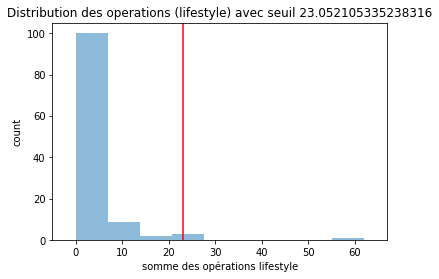

In [93]:
plot_users(sum_operation_lifestyle, 'lifestyle', threshold_lifestyle)

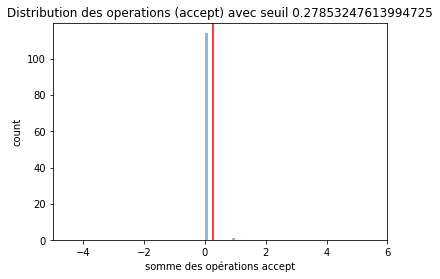

In [94]:
plot_users(sum_operation_accept, 'accept', threshold_accept)

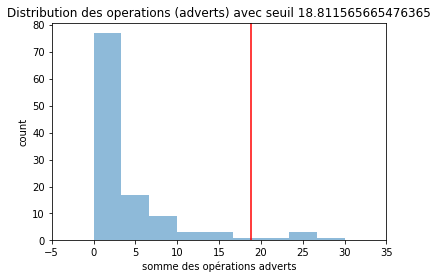

In [95]:
plot_users(sum_operation_adverts, 'adverts', threshold_adverts)

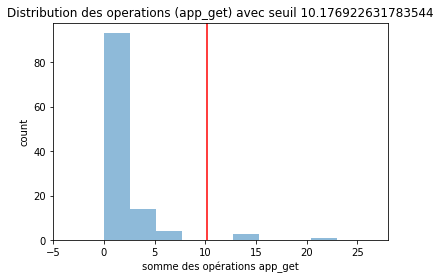

In [96]:
plot_users(sum_operation_app_get, 'app_get', threshold_app_get)

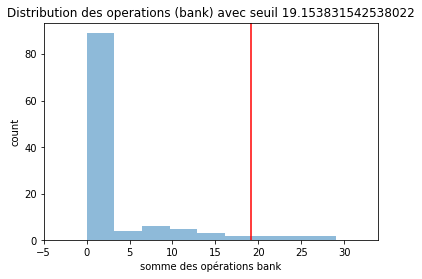

In [97]:
plot_users(sum_operation_bank, 'bank', threshold_bank)

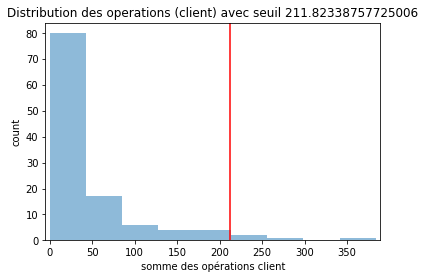

In [98]:
plot_users(sum_operation_client, 'client', threshold_client)

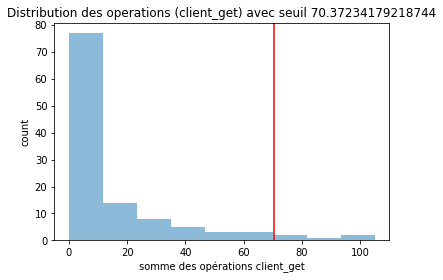

In [99]:
plot_users(sum_operation_client_get, 'client_get', threshold_client_get)

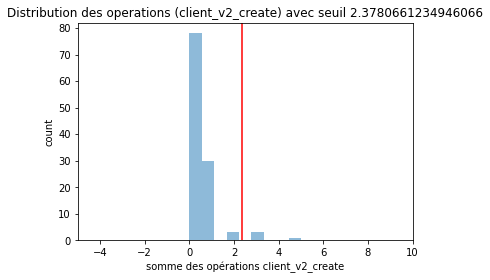

In [100]:
plot_users(sum_operation_client_v2_create, 'client_v2_create', threshold_client_v2_create)

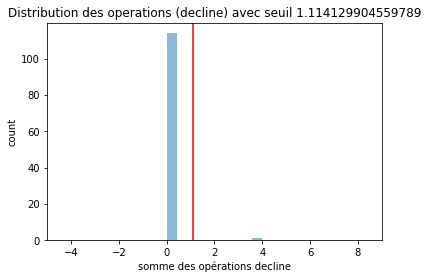

In [101]:
plot_users(sum_operation_decline, 'decline', threshold_decline)

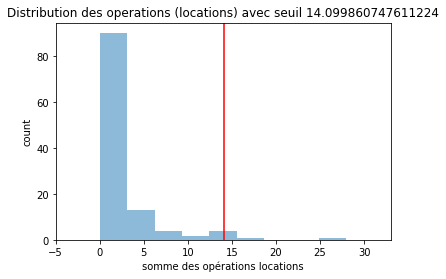

In [102]:
plot_users(sum_operation_Location, 'locations', threshold_Location)

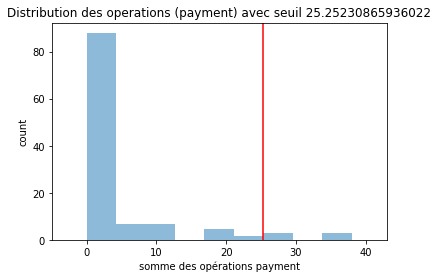

In [103]:
plot_users(sum_operation_payment, 'payment', threshold_payment)

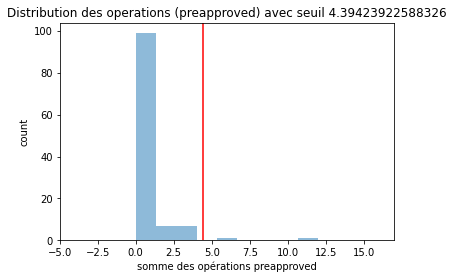

In [104]:
plot_users(sum_operation_preapproved, 'preapproved', threshold_preapproved)

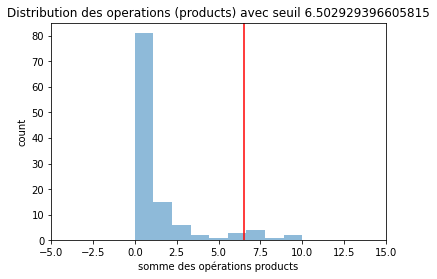

In [105]:
plot_users(sum_operation_product, 'products', threshold_product)

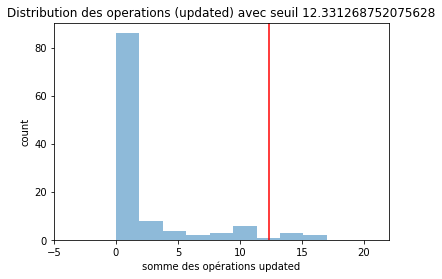

In [106]:
plot_users(sum_operation_update, 'updated', threshold_update)

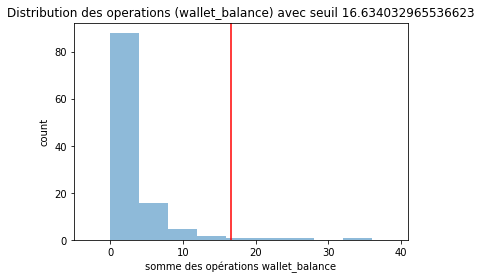

In [107]:
plot_users(sum_operation_wallet_balance, 'wallet_balance', threshold_wallet_balance)

### Regrouper les utilisateurs en fonction du seuil

In [122]:
def group_users(list_users, list_phone_number_user, threshold):
  '''cette fonction permet de regrouper les utilisateurs
    en fonction de si leurs nombres d'opérations sont supérieurs ou inférieurs
    à un seuil.  '''

  list_users_great_than_threshold = []
  list_users_less_than_threshold = []
  dict_res = {}

  for i, element in enumerate(list_users):
    if element > threshold:
      dict_res[list_phone_number_user[i]] = 1
      list_users_great_than_threshold.append(list_phone_number_user[i])
    elif element < threshold:
      dict_res[list_phone_number_user[i]] = 0
      list_users_less_than_threshold.append(list_phone_number_user[i])
  
  return dict_res

In [123]:
dict_client = group_users(sum_operation_client, list_phone_number_user_client, threshold_client)
dict_accept = group_users(sum_operation_accept, list_phone_number_user_accept, threshold_accept)
dict_adverts = group_users(sum_operation_adverts, list_phone_number_user_adverts, threshold_adverts)
dict_app_get = group_users(sum_operation_app_get, list_phone_number_user_app_get, threshold_app_get)
dict_bank = group_users(sum_operation_bank, list_phone_number_user_bank, threshold_bank)
dict_client_get = group_users(sum_operation_client_get, list_phone_number_user_client_get, threshold_client_get)
dict_client_v2_create = group_users(sum_operation_client_v2_create, list_phone_number_user_client_v2_create, threshold_client_v2_create)
dict_decline = group_users(sum_operation_decline, list_phone_number_user_decline, threshold_decline)
dict_lifestyle = group_users(sum_operation_lifestyle, list_phone_number_user_lifestyle, threshold_lifestyle)
dict_location = group_users(sum_operation_Location, list_phone_number_user_location, threshold_Location)
dict_payment = group_users(sum_operation_payment, list_phone_number_user_payment, threshold_payment)
dict_preapproved = group_users(sum_operation_preapproved, list_phone_number_user_preapproved, threshold_preapproved)
dict_product = group_users(sum_operation_product, list_phone_number_user_product, threshold_product)
dict_update = group_users(sum_operation_update, list_phone_number_user_update, threshold_update)
dict_wallet_balance = group_users(sum_operation_wallet_balance, list_phone_number_user_wallet_balance, threshold_wallet_balance)

### Créer des DataFrame en fonction des utilisateurs

In [124]:
import pandas as pd

def create_df(one_dict, key_word='great_less_than_threshold'):

  list_key = []
  list_value = []
  for key in one_dict:
    list_key.append(key)
    list_value.append(one_dict[key])

  dict_res ={'phone_number_user': list_key, key_word: list_value}
  return pd.DataFrame(dict_res)

### création du dataframe pour les utilisateurs qui ont effectué les opérations de endpoint

In [ ]:
# Création du dataframe en fonction de l'utilisation du threshold de l'endpoint "client"
df_client=create_df(dict_client, key_word='great_less_than_threshold_client')
df_client

In [ ]:
# vérifions les utilisateurs qui ont un seuil = 1
df_client[df_client['great_less_than_threshold_client'] == 1]

### création du dataframe pour les utilisateurs qui ont effectué les opérations de "accept".

In [ ]:
df_accept = create_df(dict_accept, key_word='great_less_than_threshold_accept')
df_accept

In [ ]:
df_accept[df_accept['great_less_than_threshold_accept'] == 1]

### création du dataframe pour les utilisateurs qui ont effectué les opérations de "adverts".

In [ ]:
df_adverts = create_df(dict_adverts, key_word='great_less_than_threshold_adverts')
df_adverts

In [ ]:
df_adverts[df_adverts['great_less_than_threshold_adverts'] == 1]

### création du dataframe pour les utilisateurs qui ont effectué les opérations de "application get".

In [ ]:
df_app_get = create_df(dict_app_get, key_word='great_less_than_threshold_app_get')
df_app_get

In [ ]:
df_app_get[df_app_get['great_less_than_threshold_app_get'] == 1]

### création du dataframe pour les utilisateurs qui ont effectué les opérations de "bank".

In [ ]:
df_bank = create_df(dict_bank, key_word='great_less_than_threshold_bank')
df_bank

In [ ]:
df_bank[df_bank['great_less_than_threshold_bank'] == 1]

### création du dataframe pour les utilisateurs qui ont effectué les opérations de "client get".

In [ ]:
df_client_get = create_df(dict_client_get, key_word='great_less_than_threshold_client_get')
df_client_get

In [ ]:
df_client_get[df_client_get['great_less_than_threshold_client_get'] == 1]

### création du dataframe pour les utilisateurs qui ont effectué les opérations de "client v2 create".

In [ ]:
df_client_v2_create = create_df(dict_client_v2_create, key_word='great_less_than_threshold_client_v2_create')
df_client_v2_create

In [ ]:
df_client_v2_create[df_client_v2_create['great_less_than_threshold_client_v2_create'] == 1]

### création du dataframe pour les utilisateurs qui ont effectué les opérations de "decline".

In [ ]:
df_decline = create_df(dict_decline, key_word='great_less_than_threshold_decline')
df_decline

In [ ]:
df_decline[df_decline['great_less_than_threshold_decline'] == 1]

### création du dataframe pour les utilisateurs qui ont effectué les opérations de "payment".

In [ ]:
df_payment = create_df(dict_payment, key_word='great_less_than_threshold_payment')


In [ ]:
df_payment[df_payment['great_less_than_threshold_payment'] == 1]

### création du dataframe pour les utilisateurs qui ont effectué les opérations de "lifestyle".

In [129]:
df_lifestyle = create_df(dict_lifestyle, key_word='great_less_than_threshold_lifestyle')


In [ ]:
df_lifestyle[df_lifestyle['great_less_than_threshold_lifestyle'] == 1]

### création du dataframe pour les utilisateurs qui ont effectué les opérations de "location".

In [132]:
df_location = create_df(dict_location, key_word='great_less_than_threshold_location')


In [ ]:
df_location[df_location['great_less_than_threshold_location'] == 1]

### création du dataframe pour les utilisateurs qui ont effectué les opérations de "preapproved".

In [134]:
df_preapproved = create_df(dict_preapproved, key_word='great_less_than_threshold_preapproved')


In [ ]:
df_preapproved[df_preapproved['great_less_than_threshold_preapproved'] == 1]

### création du dataframe pour les utilisateurs qui ont effectué les opérations de "products".

In [136]:
df_product = create_df(dict_product, key_word='great_less_than_threshold_products')


In [ ]:
df_product[df_product['great_less_than_threshold_products'] == 1]

### création du dataframe pour les utilisateurs qui ont effectué les opérations de "update".

In [138]:
df_update = create_df(dict_update, key_word='great_less_than_threshold_update')

In [ ]:
df_update[df_update['great_less_than_threshold_update'] == 1]

### création du dataframe pour les utilisateurs qui ont effectué les opérations de "wallet balance".

In [140]:
df_wallet_balance = create_df(dict_wallet_balance, key_word='great_less_than_threshold_wallet_balance')

In [ ]:
df_wallet_balance[df_wallet_balance['great_less_than_threshold_wallet_balance'] == 1]

### Faire la jointure des dataframes

### premièrement: ordonner les colonnes de numéros de téléphone par ordre croissant
### NB: Toujours re-indexer (.reset_index(drop=True)) les dataframe avant de faire des JOIN

In [142]:
# Ordonnons les dataset, ensuite ré-indexons les index ce qui nous facilitera l'opération de concatenation.
sorted_df_client = df_client.sort_values(by=['phone_number_user'], ascending=True).reset_index(drop=True)
sorted_df_accept = df_accept.sort_values(by=['phone_number_user'], ascending=True).reset_index(drop=True)
sorted_df_adverts = df_adverts.sort_values(by=['phone_number_user'], ascending=True).reset_index(drop=True)
sorted_df_app_get = df_app_get.sort_values(by=['phone_number_user'], ascending=True).reset_index(drop=True)
sorted_df_bank = df_bank.sort_values(by=['phone_number_user'], ascending=True).reset_index(drop=True)
sorted_df_client_get = df_client_get.sort_values(by=['phone_number_user'], ascending=True).reset_index(drop=True)
sorted_df_client_v2_create = df_client_v2_create.sort_values(by=['phone_number_user'], ascending=True).reset_index(drop=True)
sorted_df_decline = df_decline.sort_values(by=['phone_number_user'], ascending=True).reset_index(drop=True)
sorted_df_payment = df_payment.sort_values(by=['phone_number_user'], ascending=True).reset_index(drop=True)
sorted_df_lifestyle = df_lifestyle.sort_values(by=['phone_number_user'], ascending=True).reset_index(drop=True)
sorted_df_location = df_location.sort_values(by=['phone_number_user'], ascending=True).reset_index(drop=True)
sorted_df_preapproved = df_preapproved.sort_values(by=['phone_number_user'], ascending=True).reset_index(drop=True)
sorted_df_product = df_product.sort_values(by=['phone_number_user'], ascending=True).reset_index(drop=True)
sorted_df_update = df_update.sort_values(by=['phone_number_user'], ascending=True).reset_index(drop=True)
sorted_df_wallet_balance = df_wallet_balance.sort_values(by=['phone_number_user'], ascending=True).reset_index(drop=True)

### Concatenons tous les dataframes pour avoir un dataframe avec lequel on va entrainer nos modèles

In [ ]:
list_users = [sorted_df_client, sorted_df_accept['great_less_than_threshold_accept'], sorted_df_adverts['great_less_than_threshold_adverts'], sorted_df_app_get['great_less_than_threshold_app_get'], 
              sorted_df_bank['great_less_than_threshold_bank'], sorted_df_client_get['great_less_than_threshold_client_get'], 
              sorted_df_client_v2_create['great_less_than_threshold_client_v2_create'], sorted_df_decline['great_less_than_threshold_decline'], 
              sorted_df_payment['great_less_than_threshold_payment'], sorted_df_lifestyle['great_less_than_threshold_lifestyle'], 
              sorted_df_location['great_less_than_threshold_location'], sorted_df_preapproved['great_less_than_threshold_preapproved'], 
              sorted_df_product['great_less_than_threshold_products'], sorted_df_update['great_less_than_threshold_update'], 
              sorted_df_wallet_balance['great_less_than_threshold_wallet_balance']]  # List of our dataframes
df_final_users = pd.concat(list_users, axis=1)
df_final_users.head(5)

In [144]:
# Faire la somme de toutes les colonnes et mettre dans le résultat dans la colonne "score_total"
df_final_users['score_total'] = df_final_users.iloc[:, 1:16].sum(axis=1)
df_final_users['score_total'].max()

10

In [145]:
list_score_total = df_final_users['score_total'].values # convertir une series en list

In [ ]:
list_score_total

In [147]:
import numpy as np
med = np.median(list_score_total)
moy = np.mean(list_score_total)
ecart_type_score_total = np.std(list_score_total)
threshold_score_total = med + 3*ecart_type_score_total
threshold_score_total

5.024973549009185

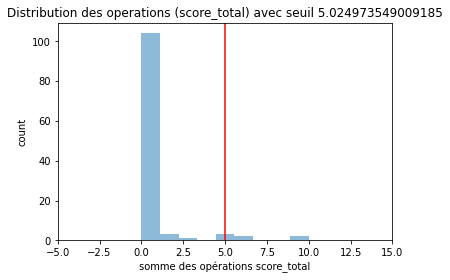

In [148]:
plot_users(df_final_users['score_total'].values, 'score_total' , threshold_score_total)

### Récupérer les utilisateurs qui sont au delà du seuil.
### les utilisateurs qui sont au délà du seuil peuvent etre considérés comme ceux qui ont effectué des transactions douteuses.

In [149]:
df_resultats = df_final_users[df_final_users['score_total'] > threshold_score_total]
df_resultats

,phone_number_user,great_less_than_threshold_client,great_less_than_threshold_accept,great_less_than_threshold_adverts,great_less_than_threshold_app_get,great_less_than_threshold_bank,great_less_than_threshold_client_get,great_less_than_threshold_client_v2_create,great_less_than_threshold_decline,great_less_than_threshold_payment,great_less_than_threshold_lifestyle,great_less_than_threshold_location,great_less_than_threshold_preapproved,great_less_than_threshold_products,great_less_than_threshold_update,great_less_than_threshold_wallet_balance,score_total
13,7060551691,1,0,0,0,1,1,0,0,1,0,0,0,1,1,0,6
28,8035455051,1,0,1,1,0,1,0,0,1,1,1,1,1,0,1,10
32,8037910994,1,0,0,0,1,1,0,0,1,0,0,0,1,1,0,6
61,9024868556,1,0,1,1,1,1,0,0,1,0,1,1,0,0,1,9


In [ ]:
df_final_users

### Selon les résultats affichés, la composantes pc2 de PCA répresente les personnes qui ont effectués beaucoup d'achats

In [151]:
 # afficher les lignes 13 et 32 du dataframe
 df_final_users.loc[[13,32],:]

,phone_number_user,great_less_than_threshold_client,great_less_than_threshold_accept,great_less_than_threshold_adverts,great_less_than_threshold_app_get,great_less_than_threshold_bank,great_less_than_threshold_client_get,great_less_than_threshold_client_v2_create,great_less_than_threshold_decline,great_less_than_threshold_payment,great_less_than_threshold_lifestyle,great_less_than_threshold_location,great_less_than_threshold_preapproved,great_less_than_threshold_products,great_less_than_threshold_update,great_less_than_threshold_wallet_balance,score_total
13,7060551691,1,0,0,0,1,1,0,0,1,0,0,0,1,1,0,6
32,8037910994,1,0,0,0,1,1,0,0,1,0,0,0,1,1,0,6


In [152]:
# afficher la ligne 54 du dataframe
 df_final_users.loc[[54],:]

,phone_number_user,great_less_than_threshold_client,great_less_than_threshold_accept,great_less_than_threshold_adverts,great_less_than_threshold_app_get,great_less_than_threshold_bank,great_less_than_threshold_client_get,great_less_than_threshold_client_v2_create,great_less_than_threshold_decline,great_less_than_threshold_payment,great_less_than_threshold_lifestyle,great_less_than_threshold_location,great_less_than_threshold_preapproved,great_less_than_threshold_products,great_less_than_threshold_update,great_less_than_threshold_wallet_balance,score_total
54,8151257660,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,3


### on drop la prémière colonne parce que les données qu'on veut passer à notre modèle de clustering doivent etre des nombres

In [153]:
df_result = df_final_users.drop('phone_number_user', 1)

### ensuite on convertit notre dataframe en liste pour le passer au  modèle de clustering KMeans

In [154]:
# convertir le dataframe en list
list_resultats = df_result.values.tolist()

### Algorithme de clustering KMeans

In [155]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

### TODO PCA

### on fait la standardisation parce que la dernière colonne du dataframe a des valeurs prépondérantes (9, 3, etc...) par rapport aux autres pour que toutes les valeurs du dataframe soient comprises entre -1 et 1.

In [156]:
from sklearn.preprocessing import StandardScaler 
Scaled_data = StandardScaler().fit_transform(list_resultats)

         pc1       pc2
13  7.502917  8.514821
32  7.502917  8.514821


Text(0, 0.5, 'pc2')

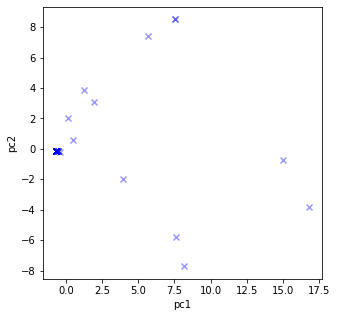

In [157]:
from sklearn.decomposition import PCA
import random

# Scale data before applying PCA
#scaling=StandardScaler()
 
# Use fit and transform method
#scaling.fit(df1)
#Scaled_data=scaling.transform(df1)
 
# Set the n_components=2
principal=PCA(n_components=2)
principal.fit(Scaled_data)
x=principal.transform(Scaled_data)
 
# Check the dimensions of data after PCA
#print(x.shape)

principal.components_

df_sortie = pd.DataFrame(x, columns=['pc1', 'pc2'])
#print(df_sortie)
df_filtre = df_sortie[(df_sortie['pc1'] >= 7) & (df_sortie['pc2'] >= 6)]
print(df_filtre)

plt.figure(figsize=(5,5))
plt.scatter(x[:,0]+random.uniform(0, 1)/10, x[:,1]+random.uniform(0, 1)/100, c='blue', cmap='plasma', marker='x', alpha=0.4)
plt.xlabel('pc1')
plt.ylabel('pc2')

In [158]:
df_filtre_1 = df_sortie[(df_sortie['pc1'] <= 5) & (df_sortie['pc2'] < -1)]
print(df_filtre_1)

         pc1       pc2
54  3.898033 -1.991714


### Fonction pour faire le plot de tous nos points

In [159]:
def scatter_plot(list_points):
  x = []
  y = []
  for i in list_points:
    x.append(i[0])
    y.append(i[1])

  plt.scatter(x,y, s=200)
  plt.show()

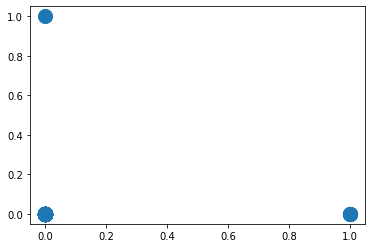

In [160]:
scatter_plot(list_resultats)

In [161]:
# on choisit trois clusters
kmeans = KMeans(n_clusters=3, random_state=0)


In [162]:
y_pred = kmeans.fit_predict(list_resultats)
y_pred


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 2, 1, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0], dtype=int32)

In [ ]:
# pour avoir la position finale de nos centroides
clusters = kmeans.cluster_centers_
# comme on peut voir dans le résultat, on a comme coordonnées de nos centroides,
# on a un tableau de 3 lignes et 16 colonnes
clusters

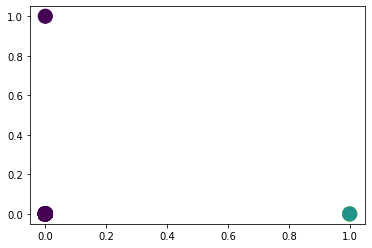

In [164]:
x = []
y = []
for i in list_resultats:
  x.append(i[0])
  y.append(i[1])

plt.scatter(x, y, c=y_pred, s=200)
plt.show()

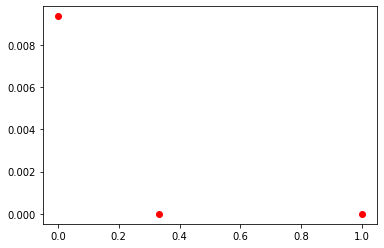

In [165]:
# on affiche tous nos centroides pour l'axe 0 et tous nos centroides pour l'axe 1
plt.scatter(clusters[:,0], clusters[:,1], c='red')
# c'est grace à ces centroides qu'on va pouvoir faire nos futures prédictions

In [166]:
# calculons la fonction cout pour notre modèle
# c'est la somme des distances entre un cluster et le centroide 
kmeans.score(list_resultats)
#kmeans.inertia_

-51.39252336448601

### essayons de chercher le nombre de cluster pour notre algorithme

In [ ]:
inertia = []
k_range = range(1, 20)
for k in k_range:
  model = KMeans(n_clusters=k).fit(list_resultats)
  inertia.append(model.inertia_)

Text(0, 0.5, 'Cout du model(Inertia)')

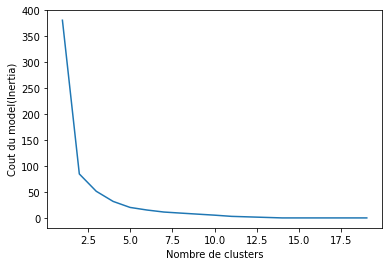

In [168]:
plt.plot(k_range, inertia)
plt.xlabel('Nombre de clusters')
plt.ylabel('Cout du model(Inertia)')
# selon le graphique ci-dessous, la zone de coude correspond à 2 clusters

### Test de silhouette qui aide à départager si on a 2 ou 3 clusters

###Autre technique pour detecter les anomalies (Isolation Forest)

In [ ]:
from sklearn.ensemble import IsolationForest
#au modèle, on indique qu'on a par exemple 2% des données de notre dataset sont contaminés
model = IsolationForest(contamination=0.02)
model.fit(list_resultats)

In [170]:
# quand on fait notre prédiction, les 1 répresentent les données qui ne sont pas des anomalies
# et les -1 répresentent les données avec anomalies. 
list_pred = model.predict(list_resultats)
# pour les filtrer et les afficher, on va faire le boolean indexing
# maintenant on doit convertir cette liste (list_pred) en une colonne et la concatener au dataframe pour avoir
# son correspondant
list_pred

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1])

In [ ]:
df_final_users['prediction_Iso_Forest'] = pd.Series(list_pred) # ajout de la prédiction de IsolationForest dans le dataframe.
df_final_users['prediction_KMeans'] = pd.Series(y_pred) # ajout de la prediction de KMeans dans le dataframe

df_final_users

### il faudrait savoir si ce modèle a bien prédit et pour cela il faudrait confronter ces données avec ce qu'on a dans le dataframe

In [ ]:
# on cherche ceux qui sont égalent à -1
outliers = model.predict(list_resultats) == -1
outliers

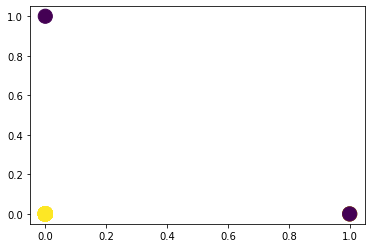

In [173]:
x = []
y = []
for i in list_resultats:
  x.append(i[0])
  y.append(i[1])

plt.scatter(x, y, c=model.predict(list_resultats), s=200)
plt.show()

### DBScan

In [ ]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=2, min_samples=3).fit(list_resultats)
clusters_dbscan = dbscan.labels_ # selon ce resultat, on 2 clusters
clusters_dbscan

In [175]:
df_final_users['prediction_dbscan'] = pd.Series(clusters_dbscan) # ajout de la prediction de DBSCAN dans le dataframe

In [176]:
from sklearn.metrics import silhouette_score
silhouette_score(list_resultats, clusters_dbscan)

0.8959268678284638

### Choisir la valeur optimale de eps:

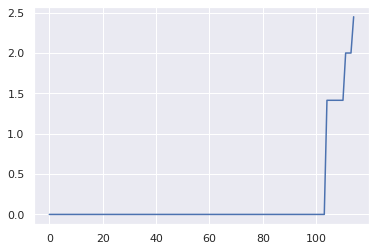

In [178]:
from sklearn.neighbors import NearestNeighbors
import seaborn as sns
sns.set()

neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(list_resultats)
distances, indices = nbrs.kneighbors(list_resultats) # distance est la distance entre 2 points
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)
# quand on trace les 115 points 

In [ ]:
indices

### Hierarchical Clustering (Agglomerative Clustering)

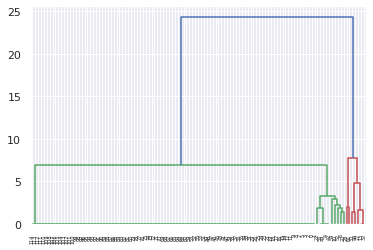

In [180]:
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch

# créons un dendogramme 
dendogram = sch.dendrogram(sch.linkage(list_resultats, method='ward'))

In [181]:
# effectuons le clustering
hc = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
# mettre chaque data point dans un cluster
y_hc = hc.fit_predict(list_resultats)
y_hc

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 2, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0])

In [ ]:
df_final_users['prediction_agglomerativeclustering'] = pd.Series(y_hc) # ajout de la prediction de Agglomerative dans le dataframe
df_final_users